In [63]:
import sys
import xlsxwriter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.svm import SVC  
from sklearn.metrics import roc_curve,classification_report, confusion_matrix  ,precision_score,recall_score,roc_auc_score,auc,f1_score

from sklearn.model_selection import train_test_split  
from sklearn.model_selection import cross_val_predict

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

import statsmodels.api as sm
import pylab

from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from statsmodels.formula.api import ols
import scipy.stats as stats

from sklearn.decomposition import PCA

import joblib

import itertools
import random
random.seed(0)
np.random.seed(0)
np.set_printoptions(threshold=sys.maxsize)
sns.set()
pd.set_option('display.max_columns', None) 

# Deep Learning Libraries
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

## Data import

In [64]:
ex=pd.ExcelFile("data_Fatma.xlsx")
#df= ex.parse('data',index_col="ID_CLT")
df= ex.parse('data')

## Data Comprehension

In [65]:
print(df.columns)
df.sample(5).T

Index(['ID_CLT', 'ANNEE_N', 'DEFAUT', 'SECTEUR', 'Appart_grp', 'Ch_Fin_EBE',
       'EBE_Ch_Fin', 'Solvabilite', 'RN_CA', 'Ch_Fin_CA', 'CP_AI', 'AI_CA',
       'CA_TOT_BL', 'Liq_Generale', 'Liq_Reduite', 'Liq_Immediat', 'CA_AE',
       'CFN_CA', 'EBE_CA', 'ROA', 'ROE', 'TN_CA', 'DT_CA', 'EBE_TOT_BL',
       'CFN_Pass_courant'],
      dtype='object')


1060        4764        7537        776         1845
ID_CLT                  2934        2337         846        1567        1629
ANNEE_N                 2012        2012        2014        2011        2011
DEFAUT                     0           0           0           0           0
SECTEUR            INDUSTRIE    COMMERCE    SERVICES   INDUSTRIE   INDUSTRIE
Appart_grp                 N           N           N           N           N
Ch_Fin_EBE        -0.0409853    0.127487    0.152056   0.0174927    0.231748
EBE_Ch_Fin           -24.399     7.84391     6.57653     57.1667     4.31503
Solvabilite         0.854891    0.139486  -0.0366031    0.628253    0.110821
RN_CA                      0    0.025324   0.0349464    0.333333  0.00697506
Ch_Fin_CA            0.82635  0.00975118   0.0199514  0.00696864   0.0326417
CP_AI                1.15786     1.25897    0.338852     1.30769    0.351738
AI_CA                177.885    0.280262     1.49931    0.347271    0.609629
CA_TOT_BL         0.00466646    0.658894     0.20161     1.60037    0.647149
Liq_Generale          1.8091     1.06231     0.73256     1.62585    0.703039
Liq_Reduite           1.8091    0.604018    0.660869     1.62585    0.196241
Liq_Immediat         0.36472   0.0858898  0.00881711   0.0408163   0.0516676
CA_AE              0.0048128     2.62943    0.666974         2.1     1.64034
CFN_CA              -20.1904   0.0558832   0.0996106    0.391405    0.109487
EBE_CA              -20.1621   0.0764874    0.131211    0.398374     0.14085
ROA                        0   0.0166859  0.00704552    0.533457   0.0045139
ROE                        0    0.119624   -0.192484    0.849112   0.0407316
TN_CA               -1.81336    0.100049 -0.00819075  -0.0220674   -0.146163
DT_CA                31.0962       1.306     5.14164    0.232288       1.374
EBE_TOT_BL        -0.0940857   0.0503971   0.0264533    0.637546   0.0911508
CFN_Pass_courant    -2.42402   0.0479744   0.0210851     2.29252   0.0822707

In [66]:
#Data types
print(df.shape)
df.dtypes

(8010, 25)


ID_CLT                int64
ANNEE_N               int64
DEFAUT                int64
SECTEUR              object
Appart_grp           object
Ch_Fin_EBE          float64
EBE_Ch_Fin          float64
Solvabilite         float64
RN_CA               float64
Ch_Fin_CA           float64
CP_AI               float64
AI_CA               float64
CA_TOT_BL           float64
Liq_Generale        float64
Liq_Reduite         float64
Liq_Immediat        float64
CA_AE               float64
CFN_CA              float64
EBE_CA              float64
ROA                 float64
ROE                 float64
TN_CA               float64
DT_CA               float64
EBE_TOT_BL          float64
CFN_Pass_courant    float64
dtype: object

### Classes count

In [67]:
df.groupby('DEFAUT').DEFAUT.count()

DEFAUT
0    7518
1     492
Name: DEFAUT, dtype: int64

### Describe numerical features

In [68]:
df.describe().T
#remove annee and defaut

count          mean            std           min  \
ID_CLT            8010.0   1453.622347     883.526460  1.000000e+00   
ANNEE_N           8010.0   2012.865418       1.371768  2.011000e+03   
DEFAUT            8010.0      0.061423       0.240120  0.000000e+00   
Ch_Fin_EBE        7858.0      0.040340       3.332025 -2.653243e+02   
EBE_Ch_Fin        6535.0     42.463756   37667.150325 -2.319327e+06   
Solvabilite       8005.0      0.325086       0.604241 -1.696903e+01   
RN_CA             7799.0      4.406374     284.787929 -6.808657e+02   
Ch_Fin_CA         7799.0      0.064303       1.446742  0.000000e+00   
CP_AI             7428.0  14691.432271  961863.844956 -6.089735e+02   
AI_CA             7799.0     15.601086     697.483335 -2.555911e-03   
CA_TOT_BL         8005.0      1.450890       1.690699 -3.740051e+01   
Liq_Generale      7937.0      9.764332     254.932816 -3.803812e+01   
Liq_Reduite       7937.0      8.094063     237.740001 -3.711557e+01   
Liq_Immediat      7937.0      1.502512      43.329920 -2.767225e+01   
CA_AE             7996.0      3.794443      12.627865  0.000000e+00   
CFN_CA            7799.0      4.526585     283.812984 -3.305509e+02   
EBE_CA            7799.0      0.015914       3.392958 -2.146094e+02   
ROA               8005.0      0.088735       0.316131 -8.473825e+00   
ROE               7969.0      0.509683      26.157618 -3.393741e+02   
TN_CA             7799.0     -0.956488      32.794859 -1.715105e+03   
DT_CA             7799.0      7.388624     361.787380 -1.168537e-02   
EBE_TOT_BL        8005.0      0.180848       0.349771 -9.661053e+00   
CFN_Pass_courant  7937.0      2.714826      81.034069 -6.328168e+02   

                          25%          50%          75%           max  
ID_CLT             702.000000  1405.000000  2187.000000  3.144000e+03  
ANNEE_N           2012.000000  2013.000000  2014.000000  2.015000e+03  
DEFAUT               0.000000     0.000000     0.000000  1.000000e+00  
Ch_Fin_EBE           0.000000     0.057912     0.166667  3.370007e+01  
EBE_Ch_Fin           2.843460     7.463542    19.153084  1.957141e+06  
Solvabilite          0.173357     0.358094     0.584747  8.293697e+00  
RN_CA                0.015750     0.056328     0.112701  1.896500e+04  
Ch_Fin_CA            0.002591     0.011150     0.029029  1.159415e+02  
CP_AI                0.973366     1.959416     5.277977  7.715053e+07  
AI_CA                0.042754     0.148247     0.428227  3.943300e+04  
CA_TOT_BL            0.623299     1.089359     1.784806  3.475790e+01  
Liq_Generale         0.959799     1.333333     2.135802  1.308473e+04  
Liq_Reduite          0.419326     0.839700     1.457127  1.308473e+04  
Liq_Immediat         0.008933     0.047516     0.201385  3.022000e+03  
CA_AE                1.056857     2.120594     3.728978  3.915029e+02  
CFN_CA               0.039673     0.092672     0.165113  1.883700e+04  
EBE_CA               0.059738     0.122172     0.208635  5.188889e+00  
ROA                  0.010216     0.061364     0.160000  1.400400e+01  
ROE                  0.049628     0.200000     0.431622  2.286214e+03  
TN_CA               -0.112557    -0.023256     0.030460  2.626727e+01  
DT_CA                0.264918     0.557696     1.050601  3.110950e+04  
EBE_TOT_BL           0.052632     0.140081     0.271854  1.285124e+01  
CFN_Pass_courant     0.052239     0.202884     0.585617  4.760375e+03

### Describe categorical features

In [69]:
sec=df.groupby('SECTEUR').SECTEUR.count()
app=df.groupby('Appart_grp').Appart_grp.count()

In [70]:
print(sec)
app


SECTEUR
COMMERCE     3264
INDUSTRIE    2250
SERVICES     2496
Name: SECTEUR, dtype: int64


Appart_grp
N    6843
O    1167
Name: Appart_grp, dtype: int64

In [71]:
df_quali = df.groupby('SECTEUR')['ID_CLT'].nunique()
df_quali

SECTEUR
COMMERCE     1279
INDUSTRIE     895
SERVICES      978
Name: ID_CLT, dtype: int64

In [72]:
df.describe(include='object')

SECTEUR Appart_grp
count       8010       8010
unique         3          2
top     COMMERCE          N
freq        3264       6843

### Missing values (NaN)

In [73]:
#Number of Nans for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8010 entries, 0 to 8009
Data columns (total 25 columns):
ID_CLT              8010 non-null int64
ANNEE_N             8010 non-null int64
DEFAUT              8010 non-null int64
SECTEUR             8010 non-null object
Appart_grp          8010 non-null object
Ch_Fin_EBE          7858 non-null float64
EBE_Ch_Fin          6535 non-null float64
Solvabilite         8005 non-null float64
RN_CA               7799 non-null float64
Ch_Fin_CA           7799 non-null float64
CP_AI               7428 non-null float64
AI_CA               7799 non-null float64
CA_TOT_BL           8005 non-null float64
Liq_Generale        7937 non-null float64
Liq_Reduite         7937 non-null float64
Liq_Immediat        7937 non-null float64
CA_AE               7996 non-null float64
CFN_CA              7799 non-null float64
EBE_CA              7799 non-null float64
ROA                 8005 non-null float64
ROE                 7969 non-null float64
TN_CA              

In [74]:
pd.DataFrame({'Percentages of MV':["{0:.2f}%".format(val * 100) for val in df.isnull().sum()/len(df)],'Numbers of MV':len(df) - df.count()}, index = (df.isnull().sum()/len(df)).index)

Percentages of MV  Numbers of MV
ID_CLT                       0.00%              0
ANNEE_N                      0.00%              0
DEFAUT                       0.00%              0
SECTEUR                      0.00%              0
Appart_grp                   0.00%              0
Ch_Fin_EBE                   1.90%            152
EBE_Ch_Fin                  18.41%           1475
Solvabilite                  0.06%              5
RN_CA                        2.63%            211
Ch_Fin_CA                    2.63%            211
CP_AI                        7.27%            582
AI_CA                        2.63%            211
CA_TOT_BL                    0.06%              5
Liq_Generale                 0.91%             73
Liq_Reduite                  0.91%             73
Liq_Immediat                 0.91%             73
CA_AE                        0.17%             14
CFN_CA                       2.63%            211
EBE_CA                       2.63%            211
ROA                          0.06%              5
ROE                          0.51%             41
TN_CA                        2.63%            211
DT_CA                        2.63%            211
EBE_TOT_BL                   0.06%              5
CFN_Pass_courant             0.91%             73

In [75]:
#delete features that have more than 10% missing  values
df=df.dropna(thresh=len(df)*0.9,axis=1)

In [76]:
pd.DataFrame({'Pourcentages MV':["{0:.2f}%".format(val * 100) for val in df.isnull().sum()/len(df)],'Nombre MV':len(df) - df.count()}, index = (df.isnull().sum()/len(df)).index)

Pourcentages MV  Nombre MV
ID_CLT                     0.00%          0
ANNEE_N                    0.00%          0
DEFAUT                     0.00%          0
SECTEUR                    0.00%          0
Appart_grp                 0.00%          0
Ch_Fin_EBE                 1.90%        152
Solvabilite                0.06%          5
RN_CA                      2.63%        211
Ch_Fin_CA                  2.63%        211
CP_AI                      7.27%        582
AI_CA                      2.63%        211
CA_TOT_BL                  0.06%          5
Liq_Generale               0.91%         73
Liq_Reduite                0.91%         73
Liq_Immediat               0.91%         73
CA_AE                      0.17%         14
CFN_CA                     2.63%        211
EBE_CA                     2.63%        211
ROA                        0.06%          5
ROE                        0.51%         41
TN_CA                      2.63%        211
DT_CA                      2.63%        211
EBE_TOT_BL                 0.06%          5
CFN_Pass_courant           0.91%         73

## Deleting lines with more than 20 missing values 

In [77]:
#Deleting lines that contains more than 20 missing values
print(len(df[df.isnull().sum(axis=1) >= 20]))
df=df[df.isnull().sum(axis=1) < 20]
df[df.isnull().sum(axis=1) >= 20]

0


Empty DataFrame
Columns: [ID_CLT, ANNEE_N, DEFAUT, SECTEUR, Appart_grp, Ch_Fin_EBE, Solvabilite, RN_CA, Ch_Fin_CA, CP_AI, AI_CA, CA_TOT_BL, Liq_Generale, Liq_Reduite, Liq_Immediat, CA_AE, CFN_CA, EBE_CA, ROA, ROE, TN_CA, DT_CA, EBE_TOT_BL, CFN_Pass_courant]
Index: []

# Data visualisation

In [78]:
df.sample(5)

ID_CLT  ANNEE_N  DEFAUT    SECTEUR Appart_grp  Ch_Fin_EBE  Solvabilite  \
3859    2425     2013       0   COMMERCE          N    0.365489     0.020655   
3076    1053     2014       0   SERVICES          N    0.131025    -0.061047   
1418    1558     2011       1  INDUSTRIE          N    0.000000     0.457692   
84      1795     2014       0   SERVICES          N    0.000000     0.999922   
2422    2133     2014       0  INDUSTRIE          N    0.097095     0.322167   

         RN_CA  Ch_Fin_CA      CP_AI     AI_CA  CA_TOT_BL  Liq_Generale  \
3859  0.035979   0.166838   0.490310  2.031623   0.427178      0.230009   
3076  0.073537   0.013684   0.748145  0.123395   2.647787      0.860376   
1418  0.149547   0.000000   5.950000  0.030211   2.546154      1.702128   
84    0.182372   0.000000  16.458164  0.044872   1.353977  12024.016222   
2422  0.122811   0.017979  33.664566  0.004661   2.053051      1.461172   

       Liq_Reduite  Liq_Immediat     CA_AE    CFN_CA    EBE_CA       ROA  \
3859      0.230009      0.055060  0.477220  0.287283  0.456479  0.015369   
3076      0.860376      0.017945  7.268928  0.065462  0.104439  0.194711   
1418      0.737589      0.063830  5.563025  0.149547  0.220544  0.380769   
84    12024.016222     24.016222  1.354083  0.182372  0.182372  0.246927   
2422      1.328025      1.049931  2.846528  0.127744  0.185173  0.252137   

           ROE     TN_CA     DT_CA  EBE_TOT_BL  CFN_Pass_courant  
3859  0.744111 -1.099344  2.292591    0.194998          0.213622  
3076 -3.189503 -0.055442  0.400730    0.276532          0.221496  
1418  0.831933  0.013595  0.212991    0.561538          0.702128  
84    0.246946  0.001386  0.000058    0.246927       3161.111111  
2422  0.782626  0.346644  0.330159    0.380169          0.386918

### Categrical features Data viz

Text(0.5, 1.0, 'Percentage of Defaults vs Non-Defaults')

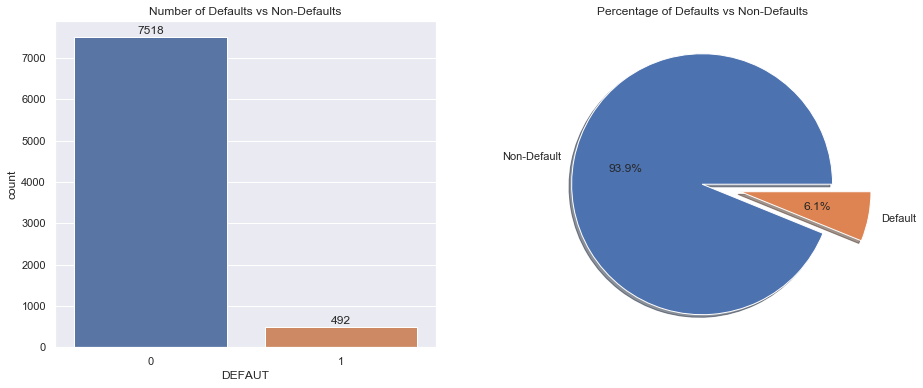

In [28]:
#Number of each category of the target variable 'DEFAUT'
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)

ax=sns.countplot('DEFAUT',data=df,)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 75,
            height,
            ha="center") 
ax.set_title('Number of Defaults vs Non-Defaults')
ax.set()
    
plt.subplot(1,2,2)
plt.pie(df.groupby('DEFAUT').DEFAUT.count(), labels=['Non-Default','Default'], autopct='%1.1f%%', shadow=True,explode=[0,0.3])
plt.title('Percentage of Defaults vs Non-Defaults')



It's clear that the data is highly imbalaned ,indeed we can see  that the ratio of defaulters is way lower than the non defaulters which is very common in default loan prediction data.

Text(0.5, 1.0, 'Number of Defauls and non-Defaults per year')

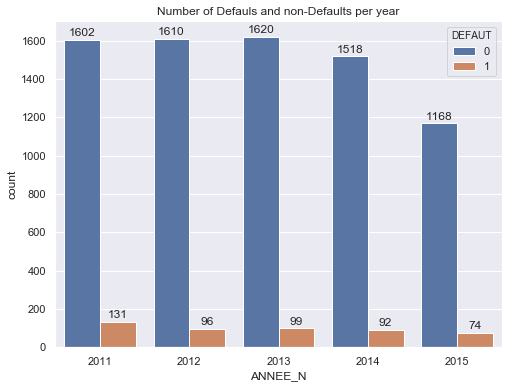

In [29]:
plt.figure(figsize=(8,6))
ax=sns.countplot('ANNEE_N',data=df,hue='DEFAUT')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 20,
            height,
            ha="center") 
ax.set_title('Number of Defauls and non-Defaults per year')

Text(0.5, 1.0, 'Number of Defauls and non-Defaults in each Sector')

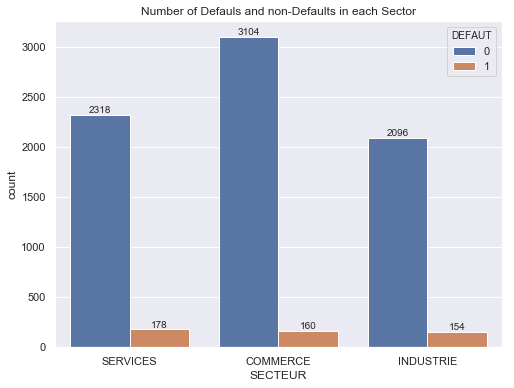

In [16]:
plt.figure(figsize=(8,6))
ax=sns.countplot('SECTEUR',data=df,hue='DEFAUT')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 20,
            height,
            ha="center") 
ax.set_title('Number of Defauls and non-Defaults in each Sector')

C:\Users\21694\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\21694\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 576x432 with 0 Axes>

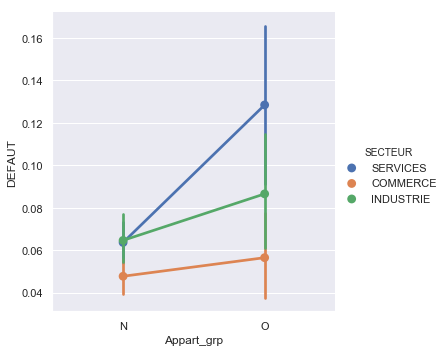

In [14]:
plt.figure(figsize=(8,6))
g = sns.factorplot(x="Appart_grp", y="DEFAUT", hue="SECTEUR",
                   data=df)

In [31]:
categorical_features_indexes = np.where(df.dtypes ==object)[0]
categorical_features_indexes

#same but with names

numeric_features =df.select_dtypes(exclude="object").columns
categorical_features =df.select_dtypes("object").columns
numeric_features_toScale=numeric_features[3:]

df_quanti=df.loc[:,numeric_features[1:]]

### Numerical features Data viz

#### Mean values yearly

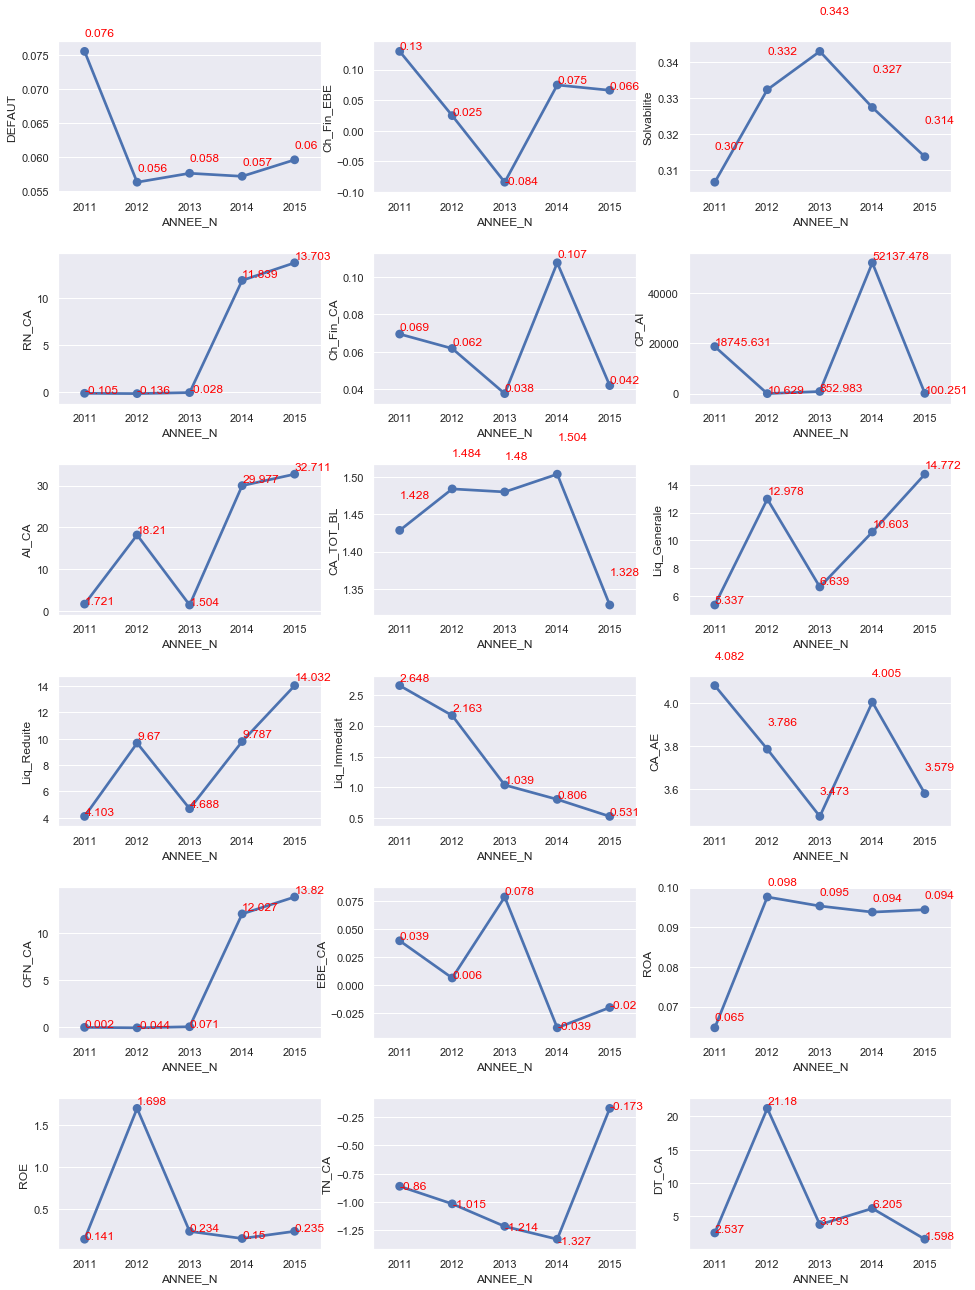

In [32]:
plt.figure(figsize=(16,30))
plt.subplots_adjust(hspace=0.4)
Grp=df.groupby('ANNEE_N').mean()
for i in range(2,20):
    plt.subplot(8,3,i-1)
    g=sns.pointplot(x=Grp[numeric_features[i]].index,y=Grp[numeric_features[i]])
    for p in zip(g.get_xticks(), Grp[numeric_features[i]]):
        g.text(p[0],p[1]*1.03, np.round(p[1],3), color='red',)
    
    

### Distribution plots and Normality Test

#### Histograms

C:\Users\21694\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


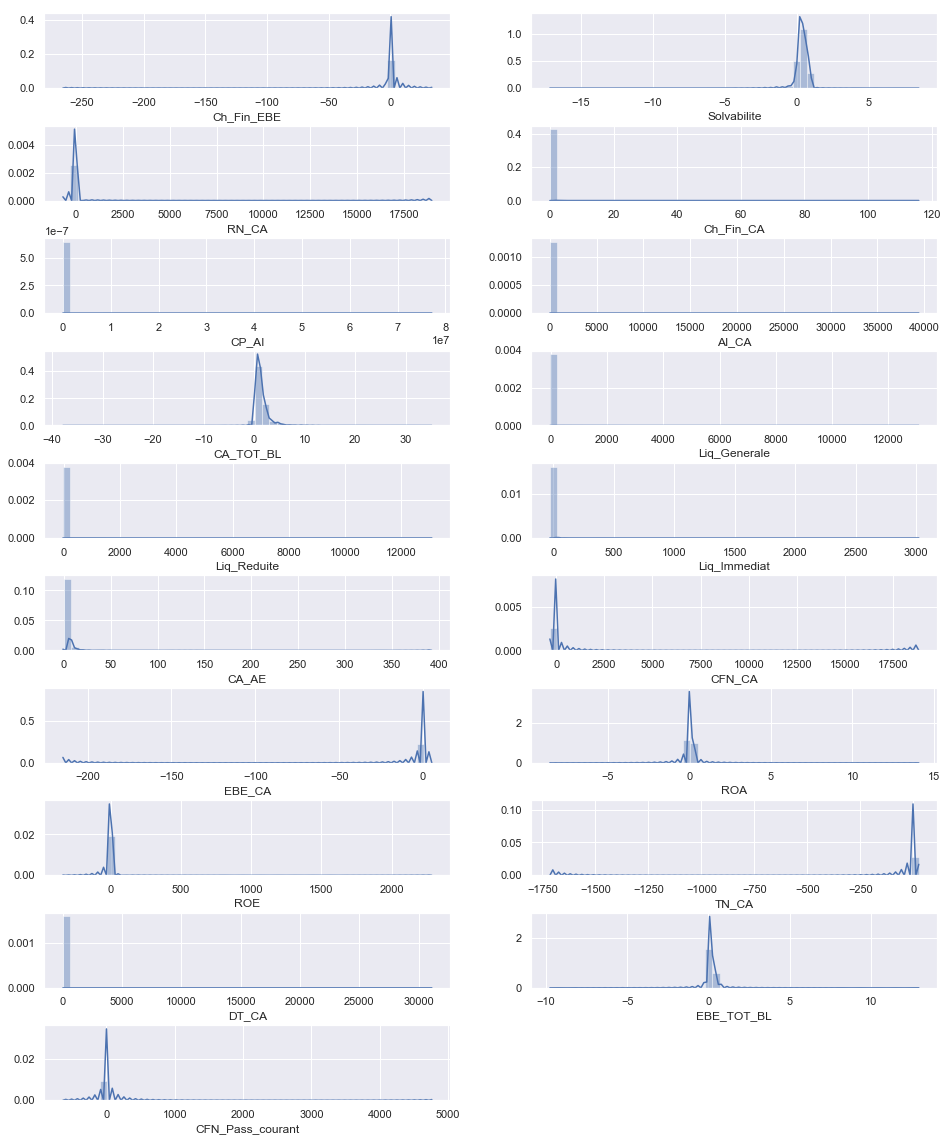

In [33]:
plt.figure(figsize=(16,20))
plt.subplots_adjust(hspace=0.5)
for i in range(1,20):
    plt.subplot(10,2,i)
    sns.distplot(df_quanti.iloc[:,i+1].dropna())

#### Boxplots

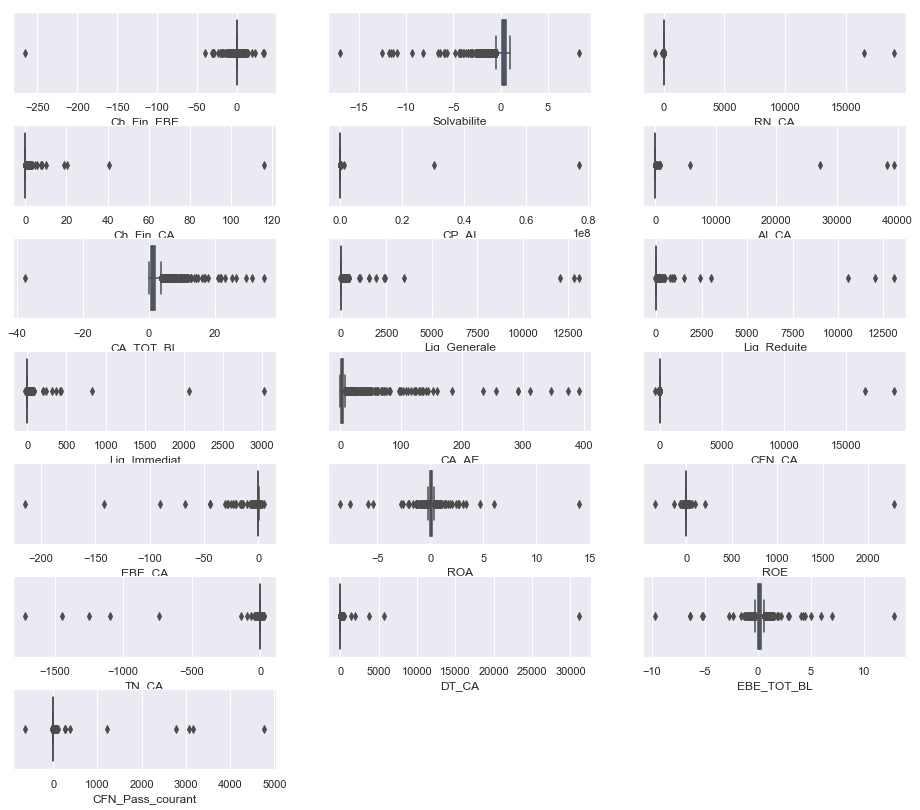

In [34]:
plt.figure(figsize=(16,16))
plt.subplots_adjust(hspace=0.4)
for i in range(1,20):
    plt.subplot(8,3,i)
    sns.boxplot(df_quanti.iloc[:,i+1].dropna())

the number of outliers makes the boxplots hard to analyze, which is a matter that will be dealt with later on.

#### QQ-plots

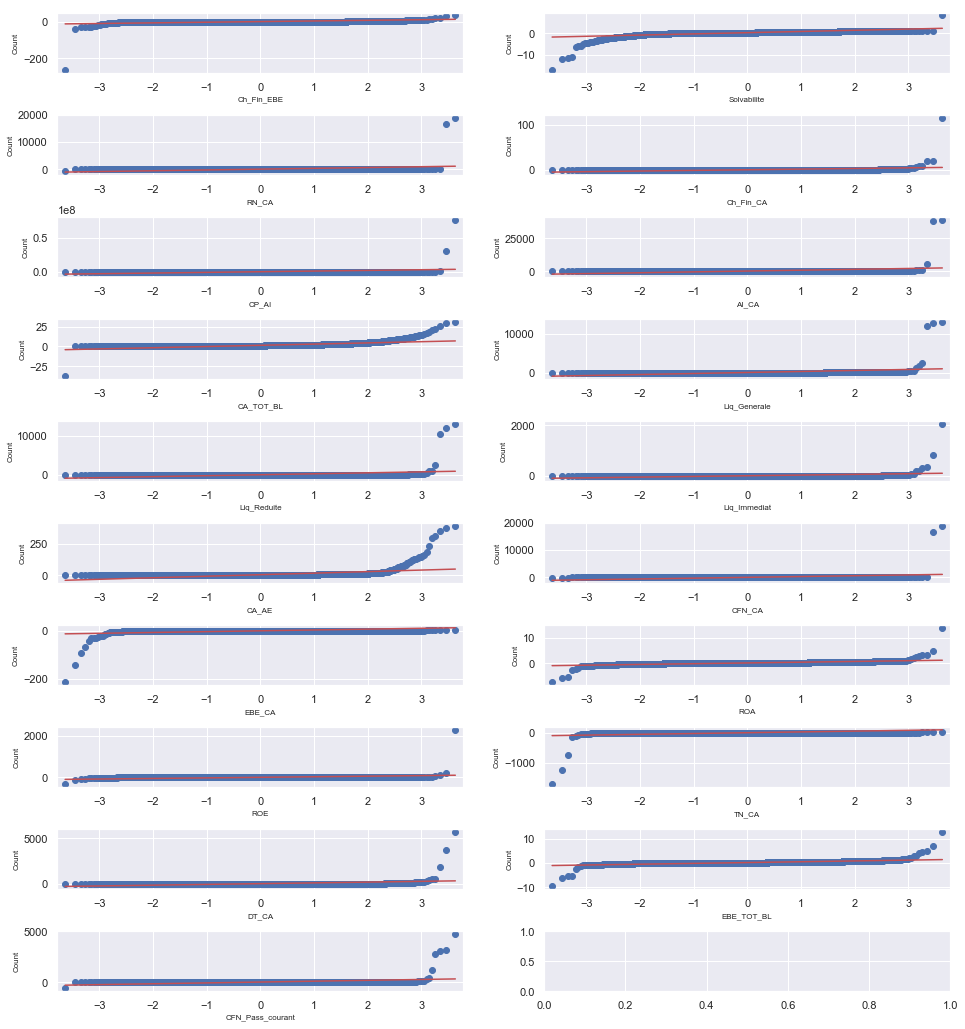

In [66]:
fig, ax = plt.subplots(((len(numeric_features)-2)//2),2, figsize=(16,18))
plt.subplots_adjust(hspace=0.7)
k=0

for i, col_val in enumerate(x for x in numeric_features if x not in ['ID_CLT','DEFAUT','ANNEE_N']):
    sm.qqplot(df.dropna()[col_val], ax=ax[i//2,k],line='s')
    ax[i//2,k].set_xlabel(col_val, fontsize=8)
    ax[i//2,k].set_ylabel('Count', fontsize=8)
    k=1-k

plt.show()

#### Normality test

In [67]:
#output is the result after Tukey method
df_Normality=pd.DataFrame(columns=['chi-square','p-value'])
for i, col_val in enumerate(x for x in numeric_features if x not in ['ID_CLT','DEFAUT','ANNEE_N']):
    df_Normality.loc[col_val]=[stats.normaltest(df_quanti.dropna()[col_val]).statistic,stats.normaltest(df_quanti.dropna()[col_val]).pvalue]
print(df_Normality)

                    chi-square  p-value
Ch_Fin_EBE        24689.339775      0.0
Solvabilite       11486.488450      0.0
RN_CA             24202.600614      0.0
Ch_Fin_CA         26264.455189      0.0
CP_AI             25788.337302      0.0
AI_CA             24026.093195      0.0
CA_TOT_BL          6318.269934      0.0
Liq_Generale      22256.261542      0.0
Liq_Reduite       22355.486562      0.0
Liq_Immediat      24973.844590      0.0
CA_AE             15648.592031      0.0
CFN_CA            24202.951581      0.0
EBE_CA            22001.620579      0.0
ROA               12402.471788      0.0
ROE               26589.722948      0.0
TN_CA             23381.456252      0.0
DT_CA             23698.376862      0.0
EBE_TOT_BL         7878.396359      0.0
CFN_Pass_courant  21496.972110      0.0


# Handling outliers 

dont run not used <br/>
outliers=[]
def detect_outlier(data_1):
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

#dont  run (z-score for outliers detection not used (tukey method instead is used later))
df_scaled=df_quanti-df_quanti.mean()/df_quanti.std()
imputer=SimpleImputer(strategy='median')
scaled_data=imputer.fit_transform(df_scaled)
scaled_data.shape
df_scaled=pd.DataFrame(scaled_data,columns=df_quanti.columns)
treshold=3
for i in range(df_scaled.shape[1]):
    for j in range(df_scaled.shape[0]):
        if (np.abs(df_scaled.iloc[j,i])>treshold):
            df_scaled.iloc[j,i]=(df_scaled.iloc[:,i]).median()

In [35]:
df_quanti.describe()

ANNEE_N       DEFAUT   Ch_Fin_EBE  Solvabilite         RN_CA  \
count  8010.000000  8010.000000  7858.000000  8005.000000   7799.000000   
mean   2012.865418     0.061423     0.040340     0.325086      4.406374   
std       1.371768     0.240120     3.332025     0.604241    284.787929   
min    2011.000000     0.000000  -265.324324   -16.969031   -680.865655   
25%    2012.000000     0.000000     0.000000     0.173357      0.015750   
50%    2013.000000     0.000000     0.057912     0.358094      0.056328   
75%    2014.000000     0.000000     0.166667     0.584747      0.112701   
max    2015.000000     1.000000    33.700065     8.293697  18965.000000   

         Ch_Fin_CA         CP_AI         AI_CA    CA_TOT_BL  Liq_Generale  \
count  7799.000000  7.428000e+03   7799.000000  8005.000000   7937.000000   
mean      0.064303  1.469143e+04     15.601086     1.450890      9.764332   
std       1.446742  9.618638e+05    697.483335     1.690699    254.932816   
min       0.000000 -6.089735e+02     -0.002556   -37.400514    -38.038124   
25%       0.002591  9.733657e-01      0.042754     0.623299      0.959799   
50%       0.011150  1.959416e+00      0.148247     1.089359      1.333333   
75%       0.029029  5.277977e+00      0.428227     1.784806      2.135802   
max     115.941495  7.715053e+07  39433.000000    34.757896  13084.728190   

        Liq_Reduite  Liq_Immediat        CA_AE        CFN_CA       EBE_CA  \
count   7937.000000   7937.000000  7996.000000   7799.000000  7799.000000   
mean       8.094063      1.502512     3.794443      4.526585     0.015914   
std      237.740001     43.329920    12.627865    283.812984     3.392958   
min      -37.115573    -27.672247     0.000000   -330.550921  -214.609426   
25%        0.419326      0.008933     1.056857      0.039673     0.059738   
50%        0.839700      0.047516     2.120594      0.092672     0.122172   
75%        1.457127      0.201385     3.728978      0.165113     0.208635   
max    13084.728190   3022.000000   391.502856  18837.000000     5.188889   

               ROA          ROE        TN_CA         DT_CA   EBE_TOT_BL  \
count  8005.000000  7969.000000  7799.000000   7799.000000  8005.000000   
mean      0.088735     0.509683    -0.956488      7.388624     0.180848   
std       0.316131    26.157618    32.794859    361.787380     0.349771   
min      -8.473825  -339.374057 -1715.104658     -0.011685    -9.661053   
25%       0.010216     0.049628    -0.112557      0.264918     0.052632   
50%       0.061364     0.200000    -0.023256      0.557696     0.140081   
75%       0.160000     0.431622     0.030460      1.050601     0.271854   
max      14.003997  2286.214185    26.267273  31109.500000    12.851245   

       CFN_Pass_courant  
count       7937.000000  
mean           2.714826  
std           81.034069  
min         -632.816762  
25%            0.052239  
50%            0.202884  
75%            0.585617  
max         4760.374938

### Tukey method (to deal with outliers)

In [36]:
#Tukey to replace missing values
Q1=df_quanti.quantile(0.25)
Q3=df_quanti.quantile(0.75)
IQR=Q3-Q1
lower_bound=Q1-(IQR*1.5)
upper_bound=Q3+(IQR*1.5)
for i in range(2,df_quanti.shape[1]):
    for j in range(df_quanti.shape[0]):
        if (df_quanti.iloc[j,i]>upper_bound[i]):
            df_quanti.iloc[j,i]=upper_bound[i]
        elif (df_quanti.iloc[j,i]<lower_bound[i]):
            df_quanti.iloc[j,i]=lower_bound[i]

In [37]:
#print(lower_bound)
#print(upper_bound)
df_quanti.describe()

ANNEE_N       DEFAUT   Ch_Fin_EBE  Solvabilite        RN_CA  \
count  8010.000000  8010.000000  7858.000000  8005.000000  7799.000000   
mean   2012.865418     0.061423     0.092394     0.364802     0.059829   
std       1.371768     0.240120     0.158449     0.311061     0.098272   
min    2011.000000     0.000000    -0.250000    -0.443727    -0.129678   
25%    2012.000000     0.000000     0.000000     0.173357     0.015750   
50%    2013.000000     0.000000     0.057912     0.358094     0.056328   
75%    2014.000000     0.000000     0.166667     0.584747     0.112701   
max    2015.000000     1.000000     0.416667     1.201832     0.258129   

         Ch_Fin_CA        CP_AI        AI_CA    CA_TOT_BL  Liq_Generale  \
count  7799.000000  7428.000000  7799.000000  8005.000000   7937.000000   
mean      0.019527     3.614398     0.294601     1.307920      1.667866   
std       0.021621     4.162545     0.333657     0.934152      1.071957   
min       0.000000    -5.483552    -0.002556    -1.118960     -0.804206   
25%       0.002591     0.973366     0.042754     0.623299      0.959799   
50%       0.011150     1.959416     0.148247     1.089359      1.333333   
75%       0.029029     5.277977     0.428227     1.784806      2.135802   
max       0.068685    11.734895     1.006437     3.527065      3.899808   

       Liq_Reduite  Liq_Immediat        CA_AE       CFN_CA       EBE_CA  \
count  7937.000000   7937.000000  7996.000000  7799.000000  7799.000000   
mean      1.085172      0.133190     2.700753     0.103989     0.138387   
std       0.882362      0.169318     2.162761     0.123256     0.141645   
min      -1.137375     -0.279744     0.000000    -0.148487    -0.163609   
25%       0.419326      0.008933     1.056857     0.039673     0.059738   
50%       0.839700      0.047516     2.120594     0.092672     0.122172   
75%       1.457127      0.201385     3.728978     0.165113     0.208635   
max       3.013828      0.490063     7.737159     0.353273     0.431982   

               ROA          ROE        TN_CA        DT_CA   EBE_TOT_BL  \
count  8005.000000  7969.000000  7799.000000  7799.000000  8005.000000   
mean      0.086759     0.241076    -0.041203     0.766356     0.173949   
std       0.140323     0.350473     0.146319     0.657711     0.183626   
min      -0.214459    -0.523363    -0.327081    -0.011685    -0.276201   
25%       0.010216     0.049628    -0.112557     0.264918     0.052632   
50%       0.061364     0.200000    -0.023256     0.557696     0.140081   
75%       0.160000     0.431622     0.030460     1.050601     0.271854   
max       0.384675     1.004612     0.244985     2.229127     0.600687   

       CFN_Pass_courant  
count       7937.000000  
mean           0.372888  
std            0.488487  
min           -0.747828  
25%            0.052239  
50%            0.202884  
75%            0.585617  
max            1.385684

In [38]:
#df_quanti.to_csv('df_quanti.csv')

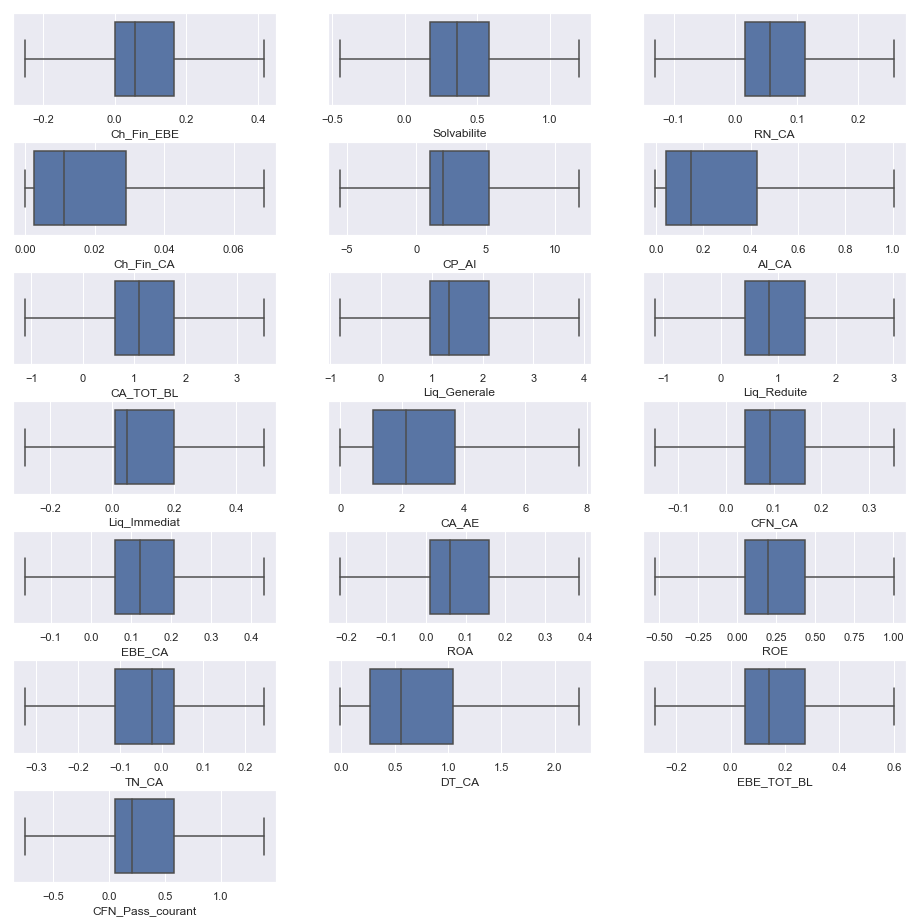

In [39]:
plt.figure(figsize=(16,16))
plt.subplots_adjust(hspace=0.4)
for i in range(1,20):
    plt.subplot(7,3,i)
    sns.boxplot(df_quanti.iloc[:,i+1])

## Multivariate analysis

### Correlation

In [40]:
df_model=pd.concat([df['ID_CLT'],df.iloc[:,categorical_features_indexes],df_quanti],axis=1)

In [41]:
df_model.sample(6)

ID_CLT    SECTEUR Appart_grp  ANNEE_N  DEFAUT  Ch_Fin_EBE  Solvabilite  \
5398    1628   COMMERCE          N     2014       0    0.045455     0.311558   
574     2063  INDUSTRIE          N     2014       0    0.124307     0.318368   
1945    1316  INDUSTRIE          N     2014       0    0.143166     0.373570   
6531    1274   SERVICES          N     2011       0   -0.250000     0.576613   
7083     660   SERVICES          N     2012       0   -0.250000     0.155894   
2011    1844  INDUSTRIE          O     2012       1   -0.250000    -0.002686   

         RN_CA  Ch_Fin_CA      CP_AI     AI_CA  CA_TOT_BL  Liq_Generale  \
5398  0.070093   0.004673  11.734895  0.004673   2.150754      1.437956   
574   0.258129   0.068685   1.096322  0.851996   0.719699      1.180204   
1945  0.059011   0.016522   1.201604  0.556519   0.804384      1.195304   
6531  0.172459   0.021961   0.845877  1.006437   0.368508      0.747216   
7083 -0.129678   0.007463   1.055182  1.006437   0.169835      3.899808   
2011       NaN        NaN  11.734895       NaN   0.000000      2.132756   

      Liq_Reduite  Liq_Immediat     CA_AE    CFN_CA    EBE_CA       ROA  \
5398     1.131387      0.490063  4.323232  0.070093  0.102804  0.150754   
574      1.146295      0.028443  0.845457  0.353273  0.431982  0.214908   
1945     0.973060      0.042004  1.269035  0.092682  0.115407  0.047468   
6531     0.747216      0.082532  0.512828 -0.146929 -0.081107  0.063553   
7083     3.013828      0.490063  0.170267 -0.022388 -0.014925 -0.031686   
2011     0.277056      0.118326  0.000000       NaN       NaN -0.105440   

           ROE     TN_CA     DT_CA  EBE_TOT_BL  CFN_Pass_courant  
5398  0.483871  0.226636  0.320093    0.221106          0.218978  
574   0.675031 -0.248730  0.947107    0.430419          1.149986  
1945  0.127065 -0.119284  0.778769    0.092832          0.161335  
6531  0.110217  0.094823  1.148920   -0.029889         -0.127884  
7083 -0.203252  0.244985  2.229127   -0.002535         -0.600000  
2011  1.004612       NaN       NaN   -0.079919         -0.215007

In [42]:
df_model.to_csv('modeling_not_scaled.csv')

#### Pearson's correlation matrix (Cont Num x Cont Num and Binary x Cont Num)

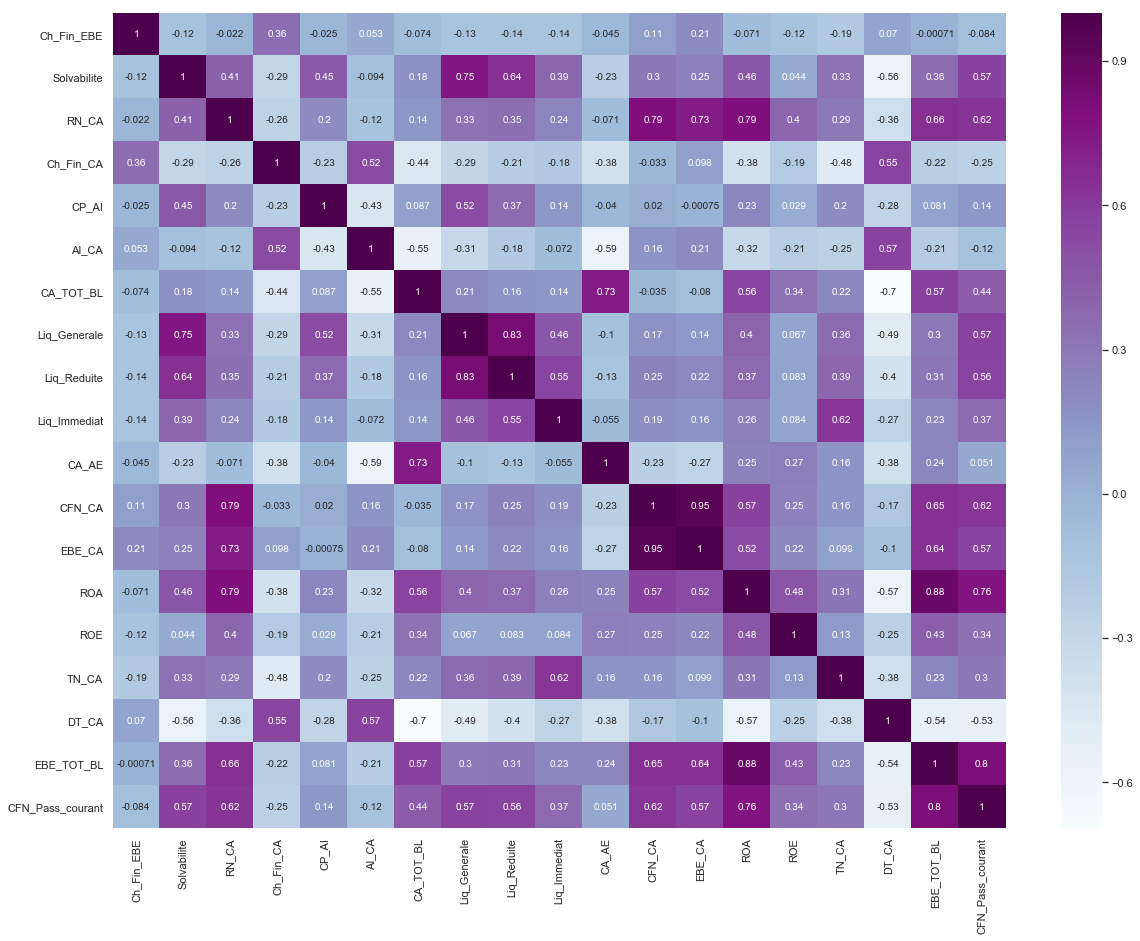

In [33]:
#pearson's formula used for calculating correlation between continuous numerical ffeatures 
#Pearson's also work with the binary feature 'DEFAUT' (known as 'point-biserial correlation coefficient')
#from scipy import stats 
plt.figure(figsize=(20,15))
cor_p = df_model.iloc[:,5:].corr(method='pearson')
sns.heatmap(cor_p.round(5), annot=True, cmap=plt.cm.BuPu,)
plt.show()

#compare with kendall , spearmann

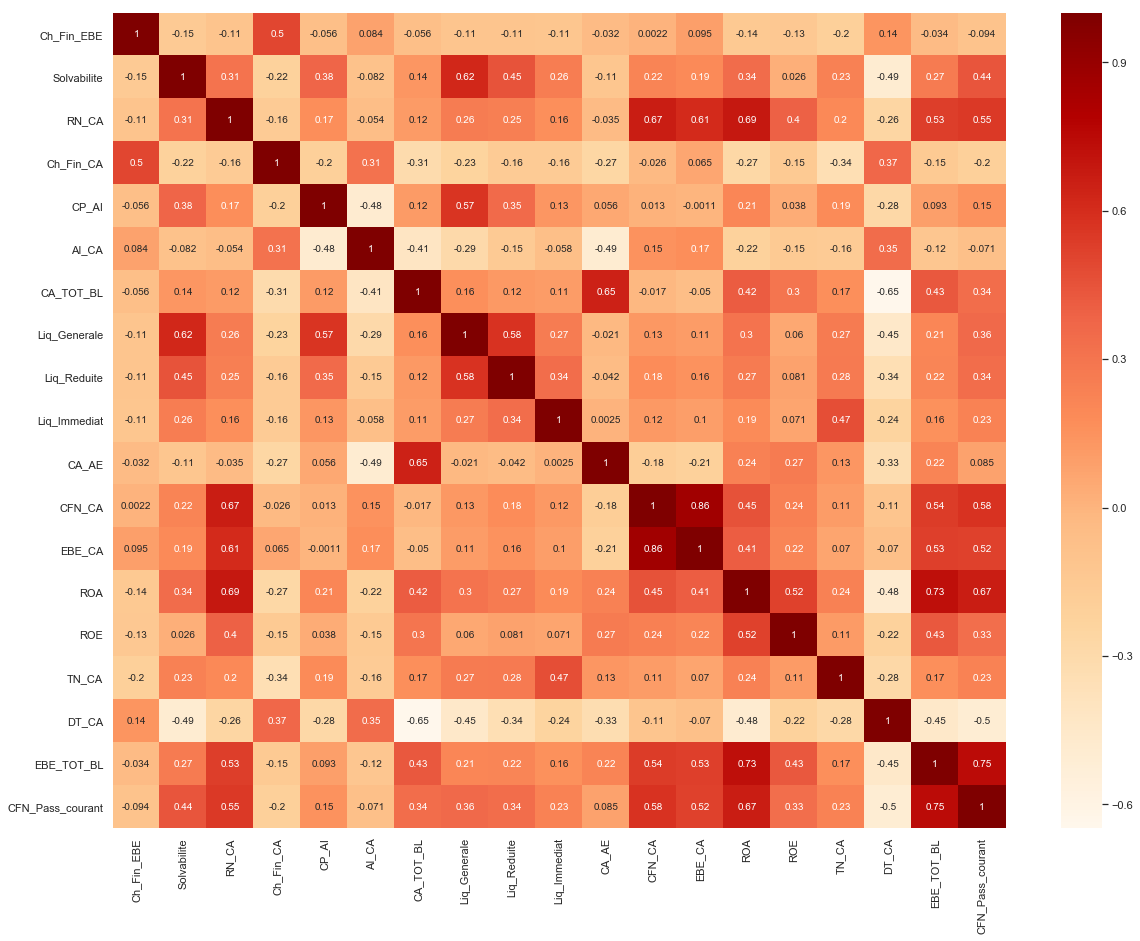

In [34]:
plt.figure(figsize=(20,15))
cor_k = df_model.iloc[:,5:].corr(method='kendall')
sns.heatmap(cor_k, annot=True, cmap=plt.cm.OrRd)
plt.show()

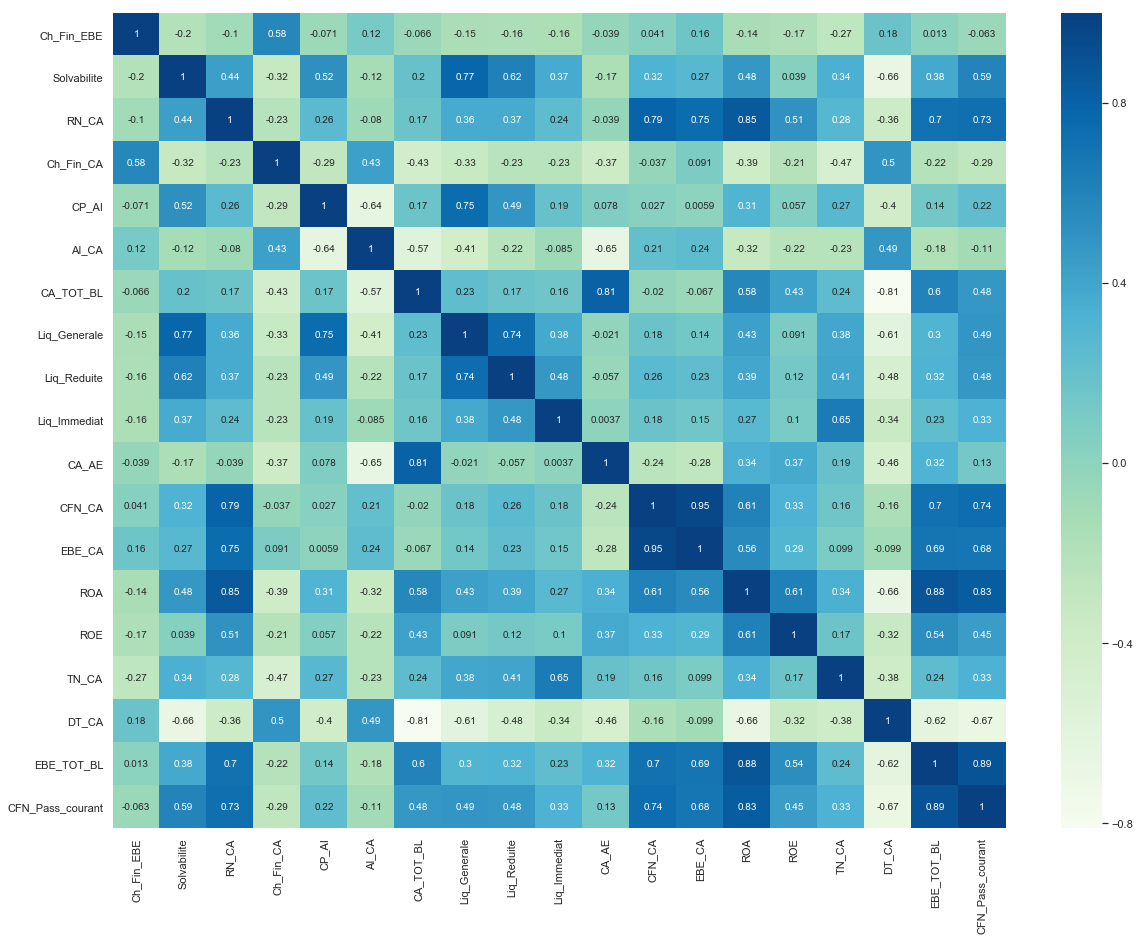

In [35]:
plt.figure(figsize=(20,15))
cor_s = df_model.iloc[:,5:].corr(method='spearman')
sns.heatmap(cor_s, annot=True, cmap=plt.cm.GnBu,)
plt.show()

# test de corrélation de pearson

In [36]:
#get a list of the highly correlated features (threshold 0.7)
list_couples_cor={}
for i in range(cor_p.shape[0]):
    for j in range(i+1,cor_p.shape[1]):
        if(cor_p.iloc[i,j]>0.7):
            list_couples_cor[cor_p.index[i]+' '+cor_p.columns[j]]=cor_p.iloc[i,j]
list_couples_cor            

{'Solvabilite Liq_Generale': 0.7535919146663973,
 'RN_CA CFN_CA': 0.791774723605596,
 'RN_CA EBE_CA': 0.7328062621315555,
 'RN_CA ROA': 0.7888804663290678,
 'CA_TOT_BL CA_AE': 0.727562181495079,
 'Liq_Generale Liq_Reduite': 0.8265201111440447,
 'CFN_CA EBE_CA': 0.9479967129857384,
 'ROA EBE_TOT_BL': 0.8789999274061814,
 'ROA CFN_Pass_courant': 0.7632516108130953,
 'EBE_TOT_BL CFN_Pass_courant': 0.803055561853064}

#### Contingency analysis with the categorical features (SECTEUR & APPART_NO)

##### Fisher exact test 

In [37]:
#this only works for 2x2 table
from scipy.stats import fisher_exact
T1=pd.crosstab(df_model.Appart_grp,df_model.DEFAUT)
print(T1)
ratio,pvalue=fisher_exact(T1)
print('pvalue chi-square test Appart_grp/DEFAUT : ',pvalue)

DEFAUT         0    1
Appart_grp           
N           6450  393
O           1068   99
pvalue chi-square test Appart_grp/DEFAUT :  0.0005769382977417148


##### chi-square test

In [38]:
#for 2xn we use chi-square test
from scipy.stats import chi2_contingency
T2=pd.crosstab(df_model.SECTEUR,df_model.DEFAUT)
print(T2)
chi2,pvalue,dof,expectedfreqs=chi2_contingency(T2)
#print(expectedfreqs)
print('pvalue chi-square test SECTEUR/DEFAUT :',pvalue)


DEFAUT        0    1
SECTEUR             
COMMERCE   3104  160
INDUSTRIE  2096  154
SERVICES   2318  178
pvalue chi-square test SECTEUR/DEFAUT : 0.0005902000226177821


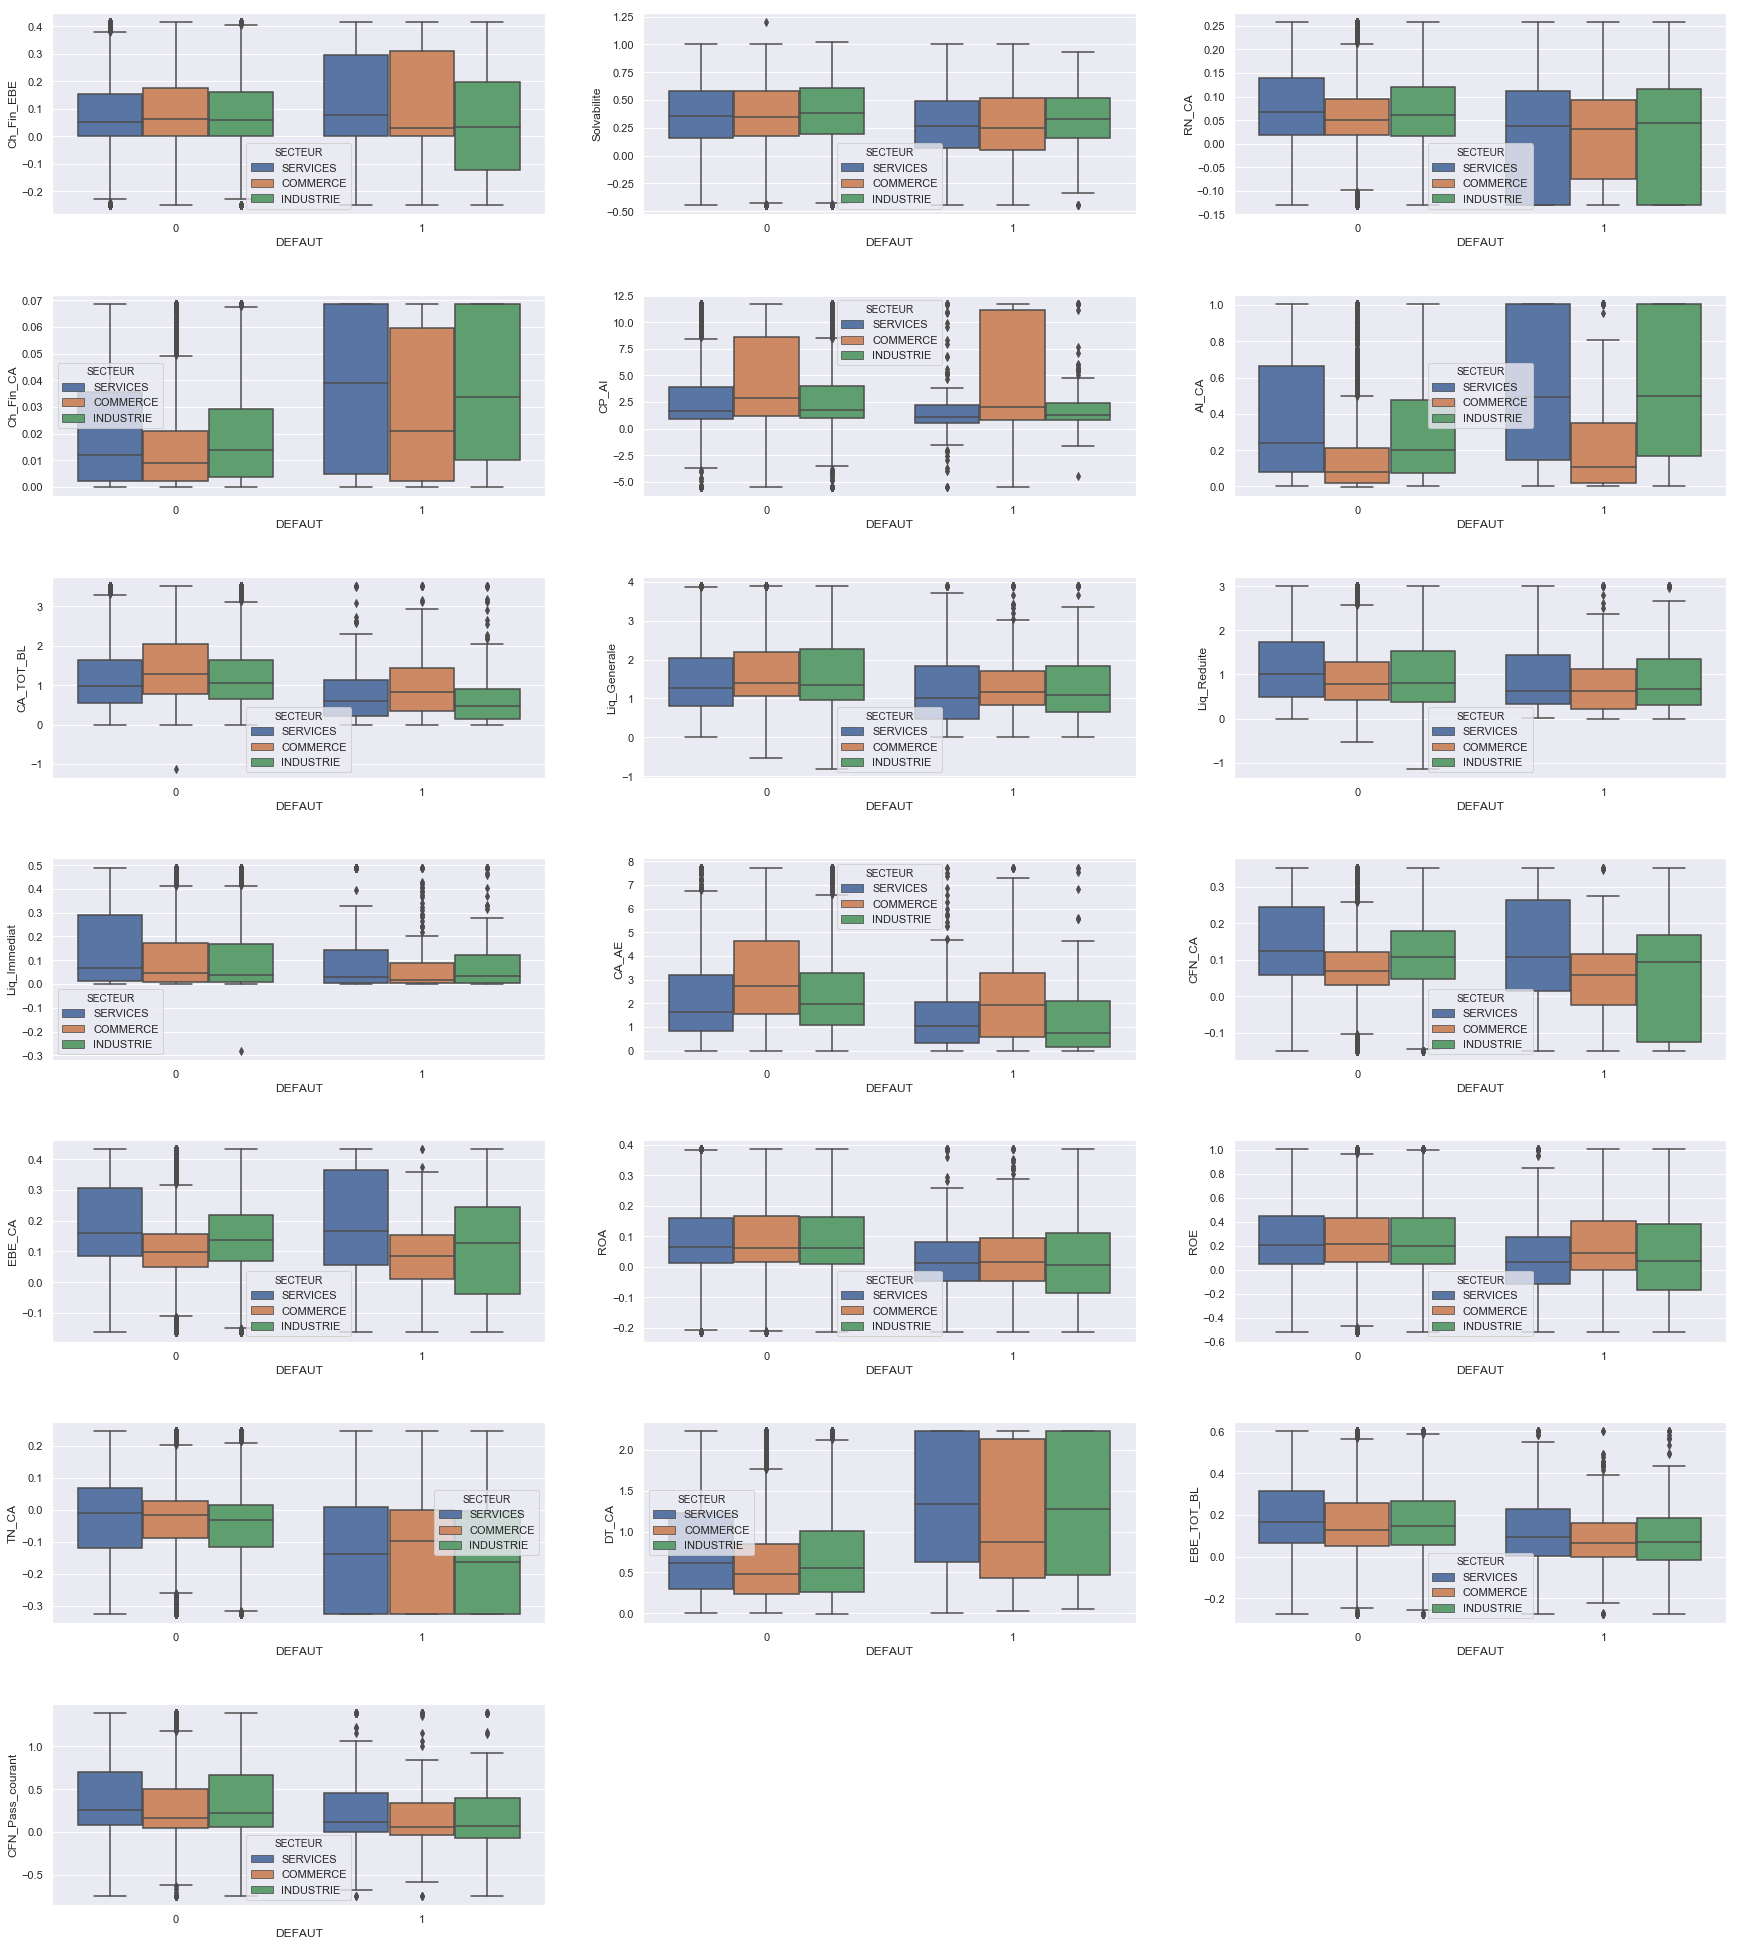

In [39]:
plt.figure(figsize=(30,40))
k=1
plt.subplots_adjust(hspace=0.4)
#[x for x in L if x not in categorical_features_indexes and x!=2]
for i in [ i for i in df_quanti.columns if i not in ['DEFAUT','ANNEE_N']]:
    plt.subplot(8,3,k)
    k+=1
    sns.boxplot(x=df_quanti.DEFAUT,y=df_quanti.loc[:,i],hue=df_model.SECTEUR)

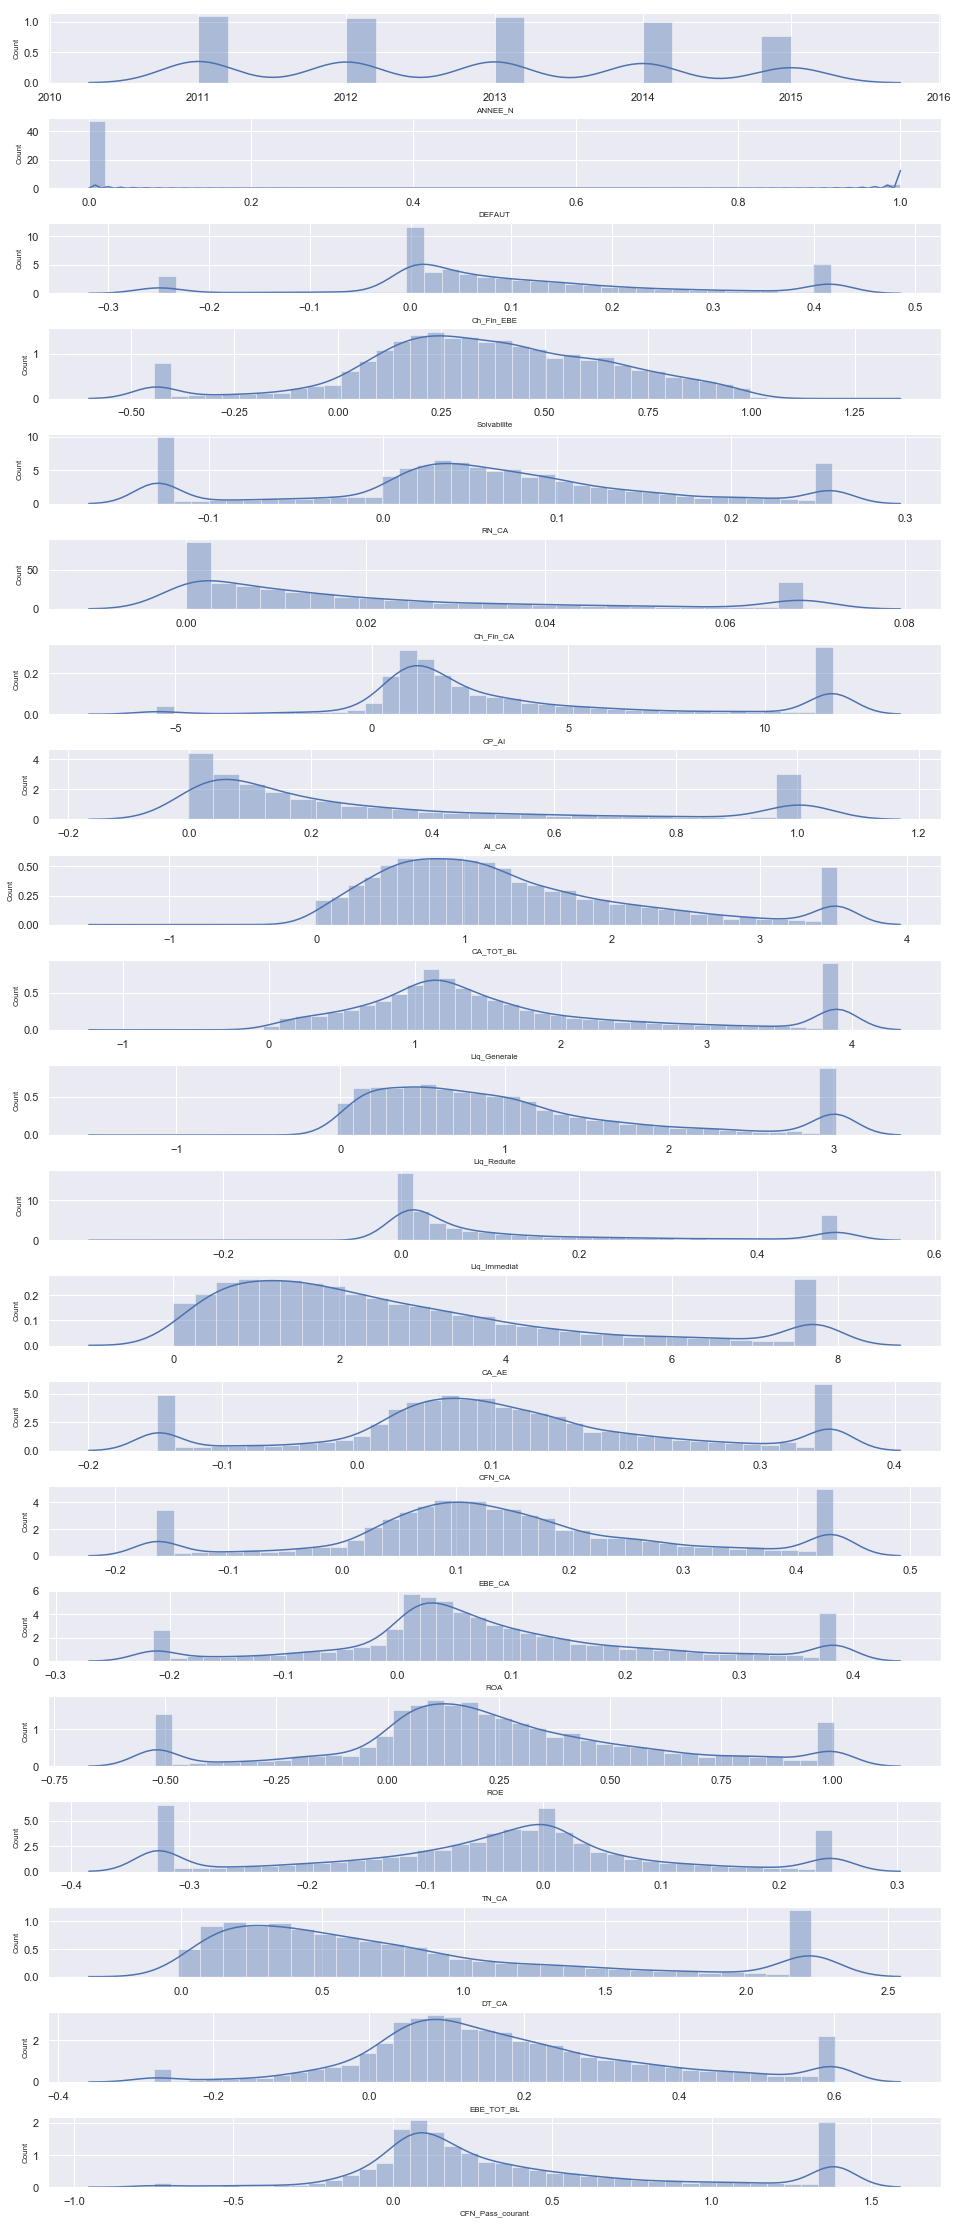

In [40]:
fig, ax = plt.subplots(len(df_quanti.columns), figsize=(16,40))
plt.subplots_adjust(hspace=0.5)

for i, col_val in enumerate(df_quanti.columns):
    sns.distplot(df_quanti.dropna()[col_val], hist=True, ax=ax[i])
    ax[i].set_xlabel(col_val, fontsize=8)
    ax[i].set_ylabel('Count', fontsize=8)

plt.show()

## Additional Statistical tests

### Variance analysis (ANOVA) 

#### 1- way ANOVA (scipy)

In [41]:
#in this case ANOVA would be equivalent to independent t-test because defaut(IV) has only 2 levels (0/1) insted  of 3+ 
# IV(independent variable) has 3+ categories while DV(Dependent variable) is continuous
from scipy.stats import f_oneway
for i in df.iloc[:,5:].columns:
    print()
    print('{:20}'.format(i), f_oneway(df.dropna().loc[:,i][df['DEFAUT']==1],df.dropna().loc[:,i][df['DEFAUT']==0]),end='\t')
#reflète la pertinence des variables + les var sont écarté + c'est mieux


Ch_Fin_EBE           F_onewayResult(statistic=1.2119031094572665, pvalue=0.2709924065474817)	
Solvabilite          F_onewayResult(statistic=21.408070374620994, pvalue=3.7770963054784545e-06)	
RN_CA                F_onewayResult(statistic=30.438401939504512, pvalue=3.5663469239527465e-08)	
Ch_Fin_CA            F_onewayResult(statistic=37.690496942470034, pvalue=8.731718220053799e-10)	
CP_AI                F_onewayResult(statistic=0.10735479289828642, pvalue=0.7431855425492462)	
AI_CA                F_onewayResult(statistic=38.89027923253379, pvalue=4.736946254629871e-10)	
CA_TOT_BL            F_onewayResult(statistic=37.89441537686513, pvalue=7.869380054332306e-10)	
Liq_Generale         F_onewayResult(statistic=0.29601177514311916, pvalue=0.58641042541143)	
Liq_Reduite          F_onewayResult(statistic=0.27644635781665367, pvalue=0.5990561357033577)	
Liq_Immediat         F_onewayResult(statistic=0.2728419389824771, pvalue=0.6014478124672082)	
CA_AE                F_onewayResult(statist

#### 2-way ANOVA 

In [42]:
numeric_features

Index(['ID_CLT', 'ANNEE_N', 'DEFAUT', 'Ch_Fin_EBE', 'Solvabilite', 'RN_CA',
       'Ch_Fin_CA', 'CP_AI', 'AI_CA', 'CA_TOT_BL', 'Liq_Generale',
       'Liq_Reduite', 'Liq_Immediat', 'CA_AE', 'CFN_CA', 'EBE_CA', 'ROA',
       'ROE', 'TN_CA', 'DT_CA', 'EBE_TOT_BL', 'CFN_Pass_courant'],
      dtype='object')

### Contingency analysis with the categorical features (SECTEUR & APPART_NO)

#### Fisher exact test 

In [43]:
#this only works for 2x2 table(not an estimation)
from scipy.stats import fisher_exact
T1=pd.crosstab(df_model.Appart_grp,df_model.DEFAUT)
print(T1)
ratio,pvalue=fisher_exact(T1)
print('pvalue fisher exact test Appart_grp/DEFAUT : ',"{0:.7f}".format(pvalue))

DEFAUT         0    1
Appart_grp           
N           6450  393
O           1068   99
pvalue fisher exact test Appart_grp/DEFAUT :  0.0005769


#### chi-square test

In [44]:
#for 2xn we use chi-square test
from scipy.stats import chi2_contingency
T2=pd.crosstab(df_model.SECTEUR,df_model.DEFAUT)
print(T2)
chi2,pvalue,dof,expectedfreqs=chi2_contingency(T2)
#print(expectedfreqs)
print('pvalue chi-square test SECTEUR/DEFAUT : ',"{0:.7f}".format(pvalue))

DEFAUT        0    1
SECTEUR             
COMMERCE   3104  160
INDUSTRIE  2096  154
SERVICES   2318  178
pvalue chi-square test SECTEUR/DEFAUT :  0.0005902


# Modeling ( Before feature selection )

## Feature selection

### Single feature importance

In [13]:
df_quanti=pd.read_csv('df_quanti.csv',index_col=0)

In [14]:
Series_Single=pd.DataFrame(columns=['Accuracy Rate'])

exclude=['DEFAUT','ID_CLT','ANNEE_N']

for l in  (l for l in df_quanti.dropna().columns.tolist() if l not in exclude):
    X=df_quanti.dropna().loc[:,l]
    y=df_quanti.dropna().DEFAUT
    Series_Single.loc['%s'%l]=(2*roc_auc_score(y,X)-1)*100 if roc_auc_score(y,X)>=0.5 else (1-2*roc_auc_score(y,X))*100

    

Series_Single.sort_values(by='Accuracy Rate',ascending=False)

Accuracy Rate
DT_CA                 35.118742
CA_TOT_BL             32.639752
TN_CA                 31.721145
Ch_Fin_CA             28.428539
CA_AE                 28.382780
ROA                   24.762356
AI_CA                 24.605711
EBE_TOT_BL            21.832940
CFN_Pass_courant      21.220009
Liq_Generale          20.420430
ROE                   18.978970
RN_CA                 18.603533
CP_AI                 16.750282
Liq_Immediat          15.329526
Solvabilite           14.767441
Liq_Reduite           13.541894
CFN_CA                 9.503960
EBE_CA                 5.198949
Ch_Fin_EBE             2.857515

### Importance of each couple of features combined

In [15]:
Series_2_features=pd.DataFrame(columns=['AUC_DT'])
L=itertools.combinations(df_quanti.dropna().columns.tolist(),2)

exclude=['DEFAUT','ID_CLT','ANNEE_N']
L=[(x,y) for x,y in L if x not in exclude and y not in exclude]
  
clf_dt=DecisionTreeClassifier(random_state=0)

for l in L :
    X=df_quanti.dropna().loc[:,l]
    y=df_quanti.dropna().DEFAUT
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,random_state=0,stratify=y) 
    clf_dt.fit(X_train,y_train)
    y_pred_dt=clf_dt.predict(X_test)
    Series_2_features.loc['%s + %s'%l]=(2*roc_auc_score(y_test,y_pred_dt)-1)*100 if roc_auc_score(y_test,y_pred_dt)>=0.5 else ((1-2*roc_auc_score(y_test,y_pred_dt))*100)
    [roc_auc_score(y_test,y_pred_dt)]
    
Series_2_features.sort_values(by='AUC_DT',ascending=False)


AUC_DT
RN_CA + CA_TOT_BL               12.309207
Ch_Fin_CA + CFN_Pass_courant    11.044876
Liq_Immediat + DT_CA            10.241260
Solvabilite + TN_CA              9.706689
Ch_Fin_EBE + CA_AE               9.485123
Solvabilite + DT_CA              8.663923
Ch_Fin_EBE + CFN_Pass_courant    8.303440
Ch_Fin_CA + Liq_Reduite          8.303440
Ch_Fin_CA + EBE_TOT_BL           7.777661
AI_CA + CFN_Pass_courant         7.482240
Liq_Reduite + DT_CA              7.334529
Ch_Fin_EBE + EBE_CA              7.316945
CA_AE + CFN_Pass_courant         7.260674
CA_TOT_BL + ROE                  7.112963
CA_TOT_BL + EBE_TOT_BL           7.030316
TN_CA + CFN_Pass_courant         6.965253
TN_CA + DT_CA                    6.882605
RN_CA + CA_AE                    6.734895
RN_CA + EBE_TOT_BL               6.669832
RN_CA + CFN_Pass_courant         6.595977
CA_TOT_BL + Liq_Immediat         6.448266
Ch_Fin_CA + CA_AE                6.365619
CFN_CA + ROE                     6.356826
Solvabilite + RN_CA              6.291763
Solvabilite + CA_AE              6.217908
Ch_Fin_CA + CA_TOT_BL            6.144053
TN_CA + EBE_TOT_BL               6.144053
Solvabilite + AI_CA              6.144053
CA_AE + TN_CA                    5.996342
Ch_Fin_EBE + RN_CA               5.987550
...                                   ...
Solvabilite + Liq_Generale       0.873954
CFN_CA + CFN_Pass_courant        0.873954
Ch_Fin_EBE + Ch_Fin_CA           0.868678
Ch_Fin_EBE + CA_TOT_BL           0.865161
RN_CA + AI_CA                    0.856369
AI_CA + Liq_Generale             0.768446
Solvabilite + CFN_Pass_courant   0.768446
Ch_Fin_CA + Liq_Generale         0.717451
CA_AE + EBE_CA                   0.643596
CFN_CA + TN_CA                   0.634803
RN_CA + Liq_Immediat             0.569740
AI_CA + DT_CA                    0.564465
CA_AE + ROA                      0.560948
Ch_Fin_EBE + Solvabilite         0.555673
Liq_Immediat + ROA               0.504677
Ch_Fin_EBE + DT_CA               0.478301
CP_AI + Liq_Generale             0.473025
Liq_Generale + DT_CA             0.413238
RN_CA + ROE                      0.404445
CP_AI + Liq_Reduite              0.399170
CA_AE + DT_CA                    0.348175
ROA + TN_CA                      0.339382
CFN_CA + DT_CA                   0.260252
Liq_Reduite + EBE_TOT_BL         0.200464
Liq_Reduite + CFN_CA             0.186397
ROE + TN_CA                      0.186397
RN_CA + Liq_Generale             0.043961
CP_AI + AI_CA                    0.043961
Ch_Fin_CA + ROA                  0.038686
AI_CA + TN_CA                    0.038686

[171 rows x 1 columns]

## SVM

In [79]:
#df_not_scaled=df_model
df_not_scaled=pd.read_csv('modeling_not_scaled_F.csv',index_col=0)

In [80]:
L_ohe=['Secteur_0','Secteur_1','Appart_0','Appart_1','Appart_2']
X=df_not_scaled.drop(['DEFAUT','ID_CLT'],axis=1)
y=df_not_scaled.DEFAUT

#### Creating preprocessing pipelines

In [81]:
#Preprocessing pieplines
#Data Preporcessing ( Categorical features (ohe) and scaling (svm is very sensitive to different scales))
numeric_features =X.select_dtypes(exclude="object").columns
print(numeric_features_toScale)
categorical_features =X.select_dtypes("object").columns
print(categorical_features)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_toScale),
        ('cat', categorical_transformer, categorical_features)])

preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features_toScale),
        ('cat', categorical_transformer, categorical_features)])



Index(['Ch_Fin_EBE', 'Solvabilite', 'RN_CA', 'Ch_Fin_CA', 'CP_AI', 'AI_CA',
       'CA_TOT_BL', 'Liq_Generale', 'Liq_Reduite', 'Liq_Immediat', 'CA_AE',
       'CFN_CA', 'EBE_CA', 'ROA', 'ROE', 'TN_CA', 'DT_CA', 'EBE_TOT_BL',
       'CFN_Pass_courant'],
      dtype='object')
Index(['SECTEUR', 'Appart_grp'], dtype='object')


#### preprocessing and model creation

In [82]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X=df_not_scaled.dropna().drop(['DEFAUT','ID_CLT','ANNEE_N'],axis=1)
y=df_not_scaled.dropna().DEFAUT

numeric_features =X.select_dtypes(exclude="object").columns
categorical_features =X.select_dtypes("object").columns
categorical_features 
L_ohe=['Secteur_0','Secteur_1','Appart_0','Appart_1','Appart_2']


In [83]:
#TO DELETE
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
#X_select=X_scaled
#y=Sample.DEFAUT

preprocessor3 = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['DT_CA', 'TN_CA', 'Ch_Fin_CA', 'ROA', 'AI_CA'])])

random.seed(0)
np.random.seed(0)
X1=df_not_scaled.dropna().loc[:,['DT_CA', 'TN_CA', 'Ch_Fin_CA', 'ROA', 'AI_CA']]
y=df_not_scaled.dropna().DEFAUT

X=preprocessor3.fit_transform(X1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=0,stratify=y)

#{'colsample_bytree': 1, 'max_depth': 6, 'min_child_weight': 8, 'reg_alpha': 0.15, 'reg_lambda': 0.25, 'scale_pos_weight': 28, 'silent': 1}
xg = XGBClassifier(n_estimators=1000,objective='binary:logistic',booster='gbtree',scale_pos_weight=35,gamma=0.15,learning_rate=0.01
                   ,max_depth=12,min_child_weight=26,reg_alpha=0.15,reg_lambda=0.2,verbosity=0,base_score=0.6) 
xg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False,eval_metric='auc')


y_pred_xg = xg.predict_proba(X_test)
y_pred_xg_classes = xg.predict(X_test)

print(confusion_matrix(y_test, y_pred_xg_classes))  
print(classification_report(y_test, y_pred_xg_classes))
print(roc_auc_score(y_test, y_pred_xg_classes))
print(roc_auc_score(y_test, y_pred_xg[:,1]))

[[924 430]
 [ 32  52]]
              precision    recall  f1-score   support

           0       0.97      0.68      0.80      1354
           1       0.11      0.62      0.18        84

    accuracy                           0.68      1438
   macro avg       0.54      0.65      0.49      1438
weighted avg       0.92      0.68      0.76      1438

0.6507350355208553
0.6946393402264892


In [104]:
L=xg.predict_proba([1, 1, 1, 1, 1]).tolist()[0]
L.index(max(L))

0

In [ ]:
joblib.dump(xg, 'xgbmodel.pkl')

##### Linear Kernel 

In [39]:
df_not_scaled.columns

Index(['ID_CLT', 'SECTEUR', 'Appart_grp', 'ANNEE_N', 'DEFAUT', 'Ch_Fin_EBE',
       'Solvabilite', 'RN_CA', 'Ch_Fin_CA', 'CP_AI', 'AI_CA', 'CA_TOT_BL',
       'Liq_Generale', 'Liq_Reduite', 'Liq_Immediat', 'CA_AE', 'CFN_CA',
       'EBE_CA', 'ROA', 'ROE', 'TN_CA', 'DT_CA', 'EBE_TOT_BL',
       'CFN_Pass_courant'],
      dtype='object')

In [40]:
df.columns

Index(['ID_CLT', 'ANNEE_N', 'DEFAUT', 'SECTEUR', 'Appart_grp', 'Ch_Fin_EBE',
       'Solvabilite', 'RN_CA', 'Ch_Fin_CA', 'CP_AI', 'AI_CA', 'CA_TOT_BL',
       'Liq_Generale', 'Liq_Reduite', 'Liq_Immediat', 'CA_AE', 'CFN_CA',
       'EBE_CA', 'ROA', 'ROE', 'TN_CA', 'DT_CA', 'EBE_TOT_BL',
       'CFN_Pass_courant'],
      dtype='object')

In [41]:
random.seed(0)
np.random.seed(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,random_state=0,stratify=y) 
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X, y, test_size = 0.20,random_state=0,stratify=y)  

X_train=preprocessor2.fit_transform(X_train)
X_test=preprocessor2.transform(X_test)
#X_train=pd.DataFrame(X_train_sc,columns=X_train.drop(['SECTEUR','Appart_grp'],axis=1).columns.tolist()+L_ohe)

#ratio=len(y_train[y_train==1])/len(y_train)
#class_weights={0:ratio, 1: 1-ratio}

X_train_sc=preprocessor.fit_transform(X_train_sc)
X_test_sc=preprocessor.transform(X_test_sc)
#X_train_sc=pd.DataFrame(X_train_sc,columns=X_train_sc.drop(['SECTEUR','Appart_grp'],axis=1).columns.tolist()+L_ohe)


svclassifier_scaled_linear= SVC(C=1,kernel='linear',class_weight='balanced',probability=True)  
svclassifier_linear = SVC(C=1,kernel='linear',class_weight='balanced',gamma='auto',probability=True)  

svclassifier_scaled_linear.fit(X_train_sc, y_train_sc)  
svclassifier_linear.fit(X_train,y_train)



print("Scaled data ")
y_pred_svm_scaled_linear = svclassifier_scaled_linear.predict_proba(X_test_sc)
y_pred_svm_scaled_linear_classes = svclassifier_scaled_linear.predict(X_test_sc)
print(confusion_matrix(y_test_sc, y_pred_svm_scaled_linear_classes))  
print(classification_report(y_test_sc, y_pred_svm_scaled_linear_classes))



print("Not scaled Scaled data ")
y_pred_svm_linear = svclassifier_linear.predict_proba(X_test)
y_pred_svm_linear_classes = svclassifier_linear.predict(X_test)
print(confusion_matrix(y_test, y_pred_svm_linear_classes))  
print(classification_report(y_test, y_pred_svm_linear_classes)) 

Scaled data 
[[1084  270]
 [  44   40]]
              precision    recall  f1-score   support

           0       0.96      0.80      0.87      1354
           1       0.13      0.48      0.20        84

    accuracy                           0.78      1438
   macro avg       0.55      0.64      0.54      1438
weighted avg       0.91      0.78      0.83      1438

Not scaled Scaled data 
[[1091  263]
 [  49   35]]
              precision    recall  f1-score   support

           0       0.96      0.81      0.87      1354
           1       0.12      0.42      0.18        84

    accuracy                           0.78      1438
   macro avg       0.54      0.61      0.53      1438
weighted avg       0.91      0.78      0.83      1438



##### RBF Kernel 

In [42]:
random.seed(0)
np.random.seed(0)
"""
ratio=len(y_train[y_train==1])/len(y_train)
class_weights={0:ratio, 1: 1-ratio}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)  

X_train_pr=preprocessor2.fit_transform(X_train)
X_train_pr=pd.DataFrame(X_train_pr,columns=X_train.drop(['SECTEUR','Appart_grp'],axis=1).columns.tolist()+L_ohe)
"""

svclassifier_rbf = SVC(C=1,kernel='rbf',class_weight='balanced',gamma='auto',degree=6,probability=True)  
svclassifier_rbf.fit(X_train, y_train)  

svclassifier_rbf_scaled= SVC(C=1,kernel='rbf',class_weight='balanced',gamma='scale',degree=6,probability=True)  
svclassifier_rbf_scaled.fit(X_train_sc, y_train_sc)  

"""
X_test_pr=preprocessor2.transform(X_test)
X_test_pr=pd.DataFrame(X_test_pr,columns=X_test.drop(['SECTEUR','Appart_grp'],axis=1).columns.tolist()+L_ohe)
"""

print("RBF scaled data")
y_pred_svm_rbf_scaled = svclassifier_rbf_scaled.predict_proba(X_test_sc)
y_pred_svm_rbf_scaled_classes = svclassifier_rbf_scaled.predict(X_test_sc)
print(confusion_matrix(y_test, y_pred_svm_rbf_scaled_classes))  
print(classification_report(y_test, y_pred_svm_rbf_scaled_classes)) 


print("RBF  unscaled data")

y_pred_svm_rbf = svclassifier_rbf.predict_proba(X_test)
y_pred_svm_rbf_classes = svclassifier_rbf.predict(X_test)
print(confusion_matrix(y_test, y_pred_svm_rbf_classes))  
print(classification_report(y_test, y_pred_svm_rbf_classes)) 


RBF scaled data
[[1115  239]
 [  39   45]]
              precision    recall  f1-score   support

           0       0.97      0.82      0.89      1354
           1       0.16      0.54      0.24        84

    accuracy                           0.81      1438
   macro avg       0.56      0.68      0.57      1438
weighted avg       0.92      0.81      0.85      1438

RBF  unscaled data
[[1053  301]
 [  41   43]]
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      1354
           1       0.12      0.51      0.20        84

    accuracy                           0.76      1438
   macro avg       0.54      0.64      0.53      1438
weighted avg       0.91      0.76      0.82      1438



##### GridsearchCV for rbf kernel SVM

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

X1=preprocessor2.transform(X)

Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
degrees=[1,2,3,4,5,6]
param_grid_svm = {'degree': degrees,'C': Cs, 'gamma' : gammas}
grid_rbf = GridSearchCV(SVC(kernel='rbf',class_weight='balanced'), param_grid=param_grid_svm, cv=5,scoring='roc_auc',verbose=5,n_jobs=-1)
grid_rbf.fit(X1, y)
print(grid_rbf.best_params_)
print(grid_rbf.cv_results_)


y_pred_svm_rbf_grid = grid_rbf.best_estimator_.predict(X_test_sc)
print(confusion_matrix(y_test_sc, y_pred_svm_rbf_grid))  
print(classification_report(y_test_sc, y_pred_svm_rbf_grid)) 

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  7.9min finished


{'C': 10, 'degree': 1, 'gamma': 0.001}
{'mean_fit_time': array([3.44919271, 3.2273685 , 3.25870819, 3.49296308, 3.22379236,
       3.21351719, 3.32734499, 3.36796131, 3.21799502, 3.28360524,
       3.32422123, 3.25861177, 3.15929241, 3.29807477, 3.30235176,
       3.23986473, 3.20549817, 3.42419829, 3.34052896, 3.3043622 ,
       3.28985286, 3.25861149, 3.21487021, 3.3148448 , 3.30235105,
       3.09614944, 3.06178336, 3.47106237, 3.14301262, 3.08052821,
       3.13363967, 3.35407333, 3.17425518, 3.13562727, 3.24923835,
       3.26485968, 3.12426748, 3.10552206, 3.21174712, 3.20862303,
       3.08990002, 3.19612589, 3.13676405, 3.1961256 , 3.24902453,
       3.23582201, 3.04928532, 3.17425475, 3.08990083, 2.78684759,
       2.59001698, 2.92431436, 3.13676476, 2.74935646, 2.57439547,
       2.91181717, 3.15256791, 2.75872779, 2.55564971, 2.89931998,
       3.11489463, 2.73060904, 2.54940186, 2.90556884, 3.14613776,
       2.71811271, 2.60251446, 2.97430186, 3.18050308, 2.72436113,
     

[[1125  229]
 [  46   38]]
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      1354
           1       0.14      0.45      0.22        84

    accuracy                           0.81      1438
   macro avg       0.55      0.64      0.55      1438
weighted avg       0.91      0.81      0.85      1438



In [54]:
y_pred_svm_rbf_grid = grid_rbf.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_pred_svm_rbf_grid))
print(classification_report(y_test, y_pred_svm_rbf_grid)) 

[[1102  252]
 [  47   37]]
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1354
           1       0.13      0.44      0.20        84

    accuracy                           0.79      1438
   macro avg       0.54      0.63      0.54      1438
weighted avg       0.91      0.79      0.84      1438



## XGBoost

In [43]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
#X_select=X_scaled
#y=Sample.DEFAUT


random.seed(0)
np.random.seed(0)
X1=df_not_scaled.dropna().drop(['DEFAUT','ID_CLT'],axis=1)
y=df_not_scaled.dropna().DEFAUT

X=preprocessor2.fit_transform(X1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=0,stratify=y)

#{'colsample_bytree': 1, 'max_depth': 6, 'min_child_weight': 8, 'reg_alpha': 0.15, 'reg_lambda': 0.25, 'scale_pos_weight': 28, 'silent': 1}
xg = XGBClassifier(n_estimators=1000,objective='binary:logistic',booster='gbtree',scale_pos_weight=35,gamma=0.15,learning_rate=0.01
                   ,max_depth=12,min_child_weight=26,reg_alpha=0.15,reg_lambda=0.2,verbosity=0,base_score=0.6) 
xg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False,eval_metric='auc')


y_pred_xg = xg.predict_proba(X_test)
y_pred_xg_classes = xg.predict(X_test)

print(confusion_matrix(y_test, y_pred_xg_classes))  
print(classification_report(y_test, y_pred_xg_classes))
print(roc_auc_score(y_test, y_pred_xg_classes))
print(roc_auc_score(y_test, y_pred_xg[:,1]))

NameError: name 'df_not_scaled' is not defined

### GridsearchCV (Xgboost)

In [1]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
XGB_params = {
    'min_child_weight': np.arange(4, 10, 2, dtype=int),  # 1 to 6, tuned to 2
    'max_depth':        np.arange(4, 8, 2, dtype=int), # 3 to 10, tuned to 3
    'colsample_bytree': [0.75,0.85,1], # 0.6 to 1, tuned to 0.6  
    'reg_lambda':       [0.25, 0.5],   # 0 to 1, tuned to 1.0
    'reg_alpha':        [0.15, 0.2],  # 0 to 1, tuned to 0.5
    'silent':           [1,],
    'scale_pos_weight': [28]
}
seed=0
XGBbase = xgb.XGBClassifier(n_estimators=150, objective= 'binary:logistic', random_state=seed, n_jobs=-1,scale_pos_weight=16)
XGBmodel = GridSearchCV(XGBbase, cv=5, n_jobs=-1, param_grid=XGB_params, scoring='accuracy_score' ,verbose=5)
_ = XGBmodel.fit(X_train, y_train)

XGBmodel
print(XGBmodel.best_estimator_)
print(XGBmodel.best_params_)
print(-round(XGBmodel.best_score_,6))
y_pred2 = XGBmodel.best_estimator_.predict(X_test)  
print(confusion_matrix(y_test, y_pred2))  
print(classification_report(y_test, y_pred2)) 

NameError: name 'np' is not defined

In [57]:
XGBmodel.cv_results_

{'mean_fit_time': array([2.83782988, 2.42443161, 2.4508822 , 2.43116517, 2.55877542,
        2.65250287, 2.55252681, 2.55565076, 2.55565147, 2.67437353,
        2.60563865, 2.54002991, 3.60502305, 3.71048565, 3.73974838,
        3.62415071, 3.63039904, 3.73037615, 3.58665891, 3.58665972,
        3.72100306, 3.72371254, 3.67335973, 3.58653774, 2.96493044,
        2.76185193, 2.77434921, 2.7493557 , 2.84933233, 2.88057413,
        2.76185231, 2.78187175, 2.80246763, 2.91181774, 2.78372288,
        2.7493556 , 3.9928134 , 4.07092123, 3.93657804, 3.92408056,
        4.10216284, 3.89596152, 3.89908557, 4.11153679, 3.87721663,
        3.88346467, 4.03655362, 3.92720327, 3.20862303, 3.3203599 ,
        3.42887325, 3.26770554, 3.17738032, 3.18987732, 3.36483626,
        3.22736893, 3.18122892, 3.18362846, 3.3242208 , 3.19925036,
        4.53643794, 4.66765571, 4.64266272, 4.54580989, 4.72701735,
        4.49894595, 4.58017654, 4.63328953, 4.48019981, 4.60517116,
        4.60829525, 4.48019967]

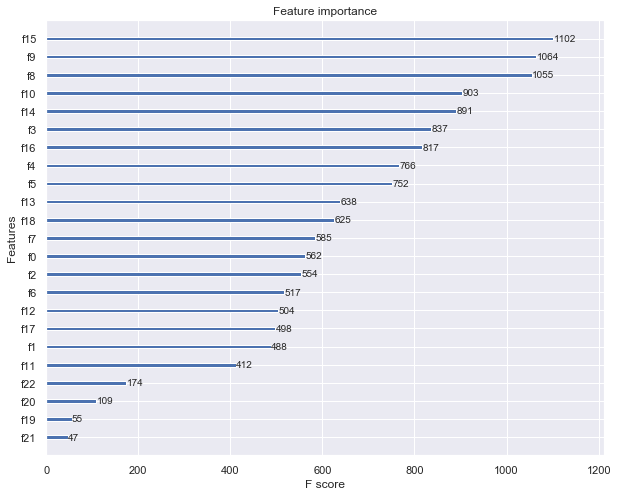

In [56]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xg, ax=ax)

### RandomForest

In [44]:
RF= RandomForestClassifier(n_estimators=100,class_weight={0:1,1:150000000},)# problem with the parameter class_weight and randomforest
RF.fit(X_train[:,:19], y_train)


y_pred_RF = RF.predict_proba(X_test[:,:19])
y_pred_RF_classes = RF.predict(X_test[:,:19])

print(confusion_matrix(y_test, y_pred_RF_classes))  
print(classification_report(y_test, y_pred_RF_classes))
print(roc_auc_score(y_test, y_pred_RF_classes))

[[943 411]
 [ 33  51]]
              precision    recall  f1-score   support

           0       0.97      0.70      0.81      1354
           1       0.11      0.61      0.19        84

    accuracy                           0.69      1438
   macro avg       0.54      0.65      0.50      1438
weighted avg       0.92      0.69      0.77      1438

0.6517989027220933


## catBoost

In [45]:
from catboost import CatBoostClassifier


np.random.seed(0)
random.seed(0)

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(df_not_scaled.dropna().drop(['DEFAUT','ID_CLT'],axis=1), df_not_scaled.dropna().DEFAUT,stratify= df_not_scaled.dropna().DEFAUT, test_size = 0.20,random_state=0) 
model_F = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    cat_features= ['SECTEUR','Appart_grp'],
    learning_rate=0.01,
    scale_pos_weight=22.5,
    eval_metric='AUC',
#     use_best_model=False
)
model_F.fit(
    X_train_cat, y_train_cat,
    eval_set=(X_test_cat, y_test_cat),
    verbose=True,
    plot=True
)

y_pred_cat = model_F.predict_proba(X_test_cat)
y_pred_cat_classes = model_F.predict(X_test_cat)
print(confusion_matrix(y_test_cat, y_pred_cat_classes))  
print(classification_report(y_test_cat, y_pred_cat_classes)) 
print(roc_auc_score(y_test_cat, y_pred_cat_classes))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6758942	best: 0.6758942 (0)	total: 206ms	remaining: 41s
1:	test: 0.6606483	best: 0.6758942 (0)	total: 307ms	remaining: 30.4s
2:	test: 0.6825807	best: 0.6825807 (2)	total: 357ms	remaining: 23.5s
3:	test: 0.6901816	best: 0.6901816 (3)	total: 411ms	remaining: 20.1s
4:	test: 0.6982750	best: 0.6982750 (4)	total: 448ms	remaining: 17.5s
5:	test: 0.6983233	best: 0.6983233 (5)	total: 477ms	remaining: 15.4s
6:	test: 0.6985783	best: 0.6985783 (6)	total: 523ms	remaining: 14.4s
7:	test: 0.7051901	best: 0.7051901 (7)	total: 579ms	remaining: 13.9s
8:	test: 0.7025436	best: 0.7051901 (7)	total: 610ms	remaining: 12.9s
9:	test: 0.7039328	best: 0.7051901 (7)	total: 653ms	remaining: 12.4s
10:	test: 0.7055242	best: 0.7055242 (10)	total: 718ms	remaining: 12.3s
11:	test: 0.7092961	best: 0.7092961 (11)	total: 779ms	remaining: 12.2s
12:	test: 0.7073794	best: 0.7092961 (11)	total: 827ms	remaining: 11.9s
13:	test: 0.7075376	best: 0.7092961 (11)	total: 877ms	remaining: 11.7s
14:	test: 0.7104303	best: 0.

117:	test: 0.7128789	best: 0.7143209 (116)	total: 6.4s	remaining: 4.45s
118:	test: 0.7127998	best: 0.7143209 (116)	total: 6.46s	remaining: 4.4s
119:	test: 0.7119997	best: 0.7143209 (116)	total: 6.51s	remaining: 4.34s
120:	test: 0.7117799	best: 0.7143209 (116)	total: 6.54s	remaining: 4.27s
121:	test: 0.7121668	best: 0.7143209 (116)	total: 6.59s	remaining: 4.21s
122:	test: 0.7120173	best: 0.7143209 (116)	total: 6.66s	remaining: 4.17s
123:	test: 0.7124481	best: 0.7143209 (116)	total: 6.73s	remaining: 4.13s
124:	test: 0.7127295	best: 0.7143209 (116)	total: 6.81s	remaining: 4.09s
125:	test: 0.7122459	best: 0.7143209 (116)	total: 6.88s	remaining: 4.04s
126:	test: 0.7114018	best: 0.7143209 (116)	total: 6.94s	remaining: 3.99s
127:	test: 0.7110414	best: 0.7143209 (116)	total: 6.98s	remaining: 3.93s
128:	test: 0.7108919	best: 0.7143209 (116)	total: 7s	remaining: 3.85s
129:	test: 0.7115074	best: 0.7143209 (116)	total: 7.06s	remaining: 3.8s
130:	test: 0.7121228	best: 0.7143209 (116)	total: 7.13s	r

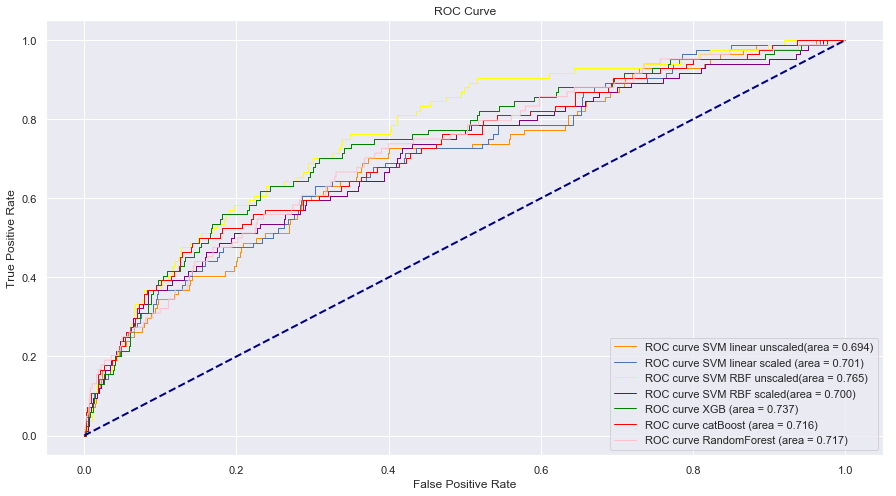

Precison score  Recall score  F1 score   AUC score  \
Linear SVM unscaled        0.117450      0.416667   0.183246   0.611214   
Linear SVM scaled          0.129032      0.476190   0.203046   0.638391   
rbf SVM unscaled           0.125000      0.511905   0.200935   0.644800   
rbf SVM scaled             0.158451      0.535714   0.244565   0.679600   
XGBoost                    0.126168      0.642857   0.210938   0.683319   
catBoost                   0.108511      0.607143   0.184116   0.648845   
RandomForest               0.110390      0.607143   0.186813   0.651799   

                     AUC proba  
Linear SVM unscaled   0.693712  
Linear SVM scaled     0.700781  
rbf SVM unscaled      0.764753  
rbf SVM scaled        0.699559  
XGBoost               0.736882  
catBoost              0.715816  
RandomForest          0.717099

In [48]:
fpr_svm_scaled, tpr_svm_scaled, thresholds = roc_curve(y_test, y_pred_svm_scaled_linear[:,1])
fpr_svm, tpr_svm, thresholds = roc_curve(y_test_sc, y_pred_svm_linear[:,1])
fpr_svm_rbf_scaled, tpr_svm_rbf_scaled, thresholds = roc_curve(y_test_sc, y_pred_svm_rbf_scaled[:,1])
fpr_svm_rbf, tpr_svm_rbf, thresholds = roc_curve(y_test, y_pred_svm_rbf[:,1])
fpr_xg, tpr_xg, thresholds = roc_curve(y_test, y_pred_xg[:,1])
fpr_cat, tpr_cat, thresholds = roc_curve(y_test, y_pred_cat[:,1])
fpr_RF, tpr_RF, thresholds = roc_curve(y_test, y_pred_RF[:,1])



plt.figure(figsize=(15,8))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=1, label='ROC curve SVM linear unscaled(area = %0.3f)' % auc(fpr_svm,tpr_svm))
plt.plot(fpr_svm_scaled, tpr_svm_scaled, lw=1, label='ROC curve SVM linear scaled (area = %0.3f)' % auc(fpr_svm_scaled,tpr_svm_scaled))
plt.plot(fpr_svm_rbf_scaled, tpr_svm_rbf_scaled, color='yellow', lw=1, label='ROC curve SVM RBF unscaled(area = %0.3f)' % auc(fpr_svm_rbf_scaled,tpr_svm_rbf_scaled))
plt.plot(fpr_svm_rbf, tpr_svm_rbf,color='purple', lw=1, label='ROC curve SVM RBF scaled(area = %0.3f)' % auc(fpr_svm_rbf,tpr_svm_rbf))
plt.plot(fpr_xg, tpr_xg, lw=1,color='green', label='ROC curve XGB (area = %0.3f)' % auc(fpr_xg,tpr_xg))
plt.plot(fpr_cat, tpr_cat, lw=1,color='red', label='ROC curve catBoost (area = %0.3f)' % auc(fpr_cat,tpr_cat))
plt.plot(fpr_RF, tpr_RF, lw=1,color='pink', label='ROC curve RandomForest (area = %0.3f)' % auc(fpr_RF,tpr_RF))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


df_Evaluation=pd.DataFrame(columns=['Precison score','Recall score','F1 score ', 'AUC score','AUC proba'])
df_Evaluation.loc['Linear SVM unscaled']=[precision_score(y_test, y_pred_svm_linear_classes),recall_score(y_test, y_pred_svm_linear_classes),f1_score(y_test, y_pred_svm_linear_classes),roc_auc_score(y_test, y_pred_svm_linear_classes),auc(fpr_svm,tpr_svm)]
df_Evaluation.loc['Linear SVM scaled']=[precision_score(y_test, y_pred_svm_scaled_linear_classes),recall_score(y_test, y_pred_svm_scaled_linear_classes),f1_score(y_test, y_pred_svm_scaled_linear_classes),roc_auc_score(y_test, y_pred_svm_scaled_linear_classes),auc(fpr_svm_scaled,tpr_svm_scaled)]
df_Evaluation.loc['rbf SVM unscaled']=[precision_score(y_test, y_pred_svm_rbf_classes),recall_score(y_test, y_pred_svm_rbf_classes),f1_score(y_test, y_pred_svm_rbf_classes),roc_auc_score(y_test, y_pred_svm_rbf_classes),auc(fpr_svm_rbf_scaled,tpr_svm_rbf_scaled)]
df_Evaluation.loc['rbf SVM scaled']=[precision_score(y_test, y_pred_svm_rbf_scaled_classes),recall_score(y_test, y_pred_svm_rbf_scaled_classes),f1_score(y_test, y_pred_svm_rbf_scaled_classes),roc_auc_score(y_test, y_pred_svm_rbf_scaled_classes),auc(fpr_svm_rbf,tpr_svm_rbf)]
df_Evaluation.loc['XGBoost']=[precision_score(y_test, y_pred_xg_classes),recall_score(y_test, y_pred_xg_classes),f1_score(y_test, y_pred_xg_classes),roc_auc_score(y_test, y_pred_xg_classes),auc(fpr_xg,tpr_xg)]
df_Evaluation.loc['catBoost']=[precision_score(y_test, y_pred_cat_classes),recall_score(y_test, y_pred_cat_classes),f1_score(y_test, y_pred_cat_classes),roc_auc_score(y_test, y_pred_cat_classes),auc(fpr_cat,tpr_cat)]
df_Evaluation.loc['RandomForest']=[precision_score(y_test, y_pred_RF_classes),recall_score(y_test, y_pred_RF_classes),f1_score(y_test, y_pred_RF_classes),roc_auc_score(y_test, y_pred_RF_classes),auc(fpr_RF,tpr_RF)]

df_Evaluation


## Cross Validation

In [89]:
X1=df_not_scaled.dropna().drop(['DEFAUT','ID_CLT'],axis=1)
y=df_not_scaled.dropna().DEFAUT

X=preprocessor2.fit_transform(X1)

proba_xg=cross_val_predict(xg,X,y,cv=5,method='predict_proba')
proba_xg_classes=cross_val_predict(xg,X,y,cv=5,method='predict')

In [90]:
X,y=df_not_scaled.dropna().drop(['DEFAUT','ID_CLT'],axis=1), df_not_scaled.dropna().DEFAUT

proba_cat=cross_val_predict(model_F,X,y,cv=5,method='predict_proba')
proba_cat_classes=cross_val_predict(model_F,X,y,cv=5,method='predict')

0:	total: 63.1ms	remaining: 12.6s
1:	total: 133ms	remaining: 13.2s
2:	total: 197ms	remaining: 12.9s
3:	total: 268ms	remaining: 13.1s
4:	total: 334ms	remaining: 13s
5:	total: 403ms	remaining: 13s
6:	total: 434ms	remaining: 12s
7:	total: 496ms	remaining: 11.9s
8:	total: 566ms	remaining: 12s
9:	total: 633ms	remaining: 12s
10:	total: 702ms	remaining: 12.1s
11:	total: 769ms	remaining: 12.1s
12:	total: 843ms	remaining: 12.1s
13:	total: 881ms	remaining: 11.7s
14:	total: 939ms	remaining: 11.6s
15:	total: 1s	remaining: 11.6s
16:	total: 1.04s	remaining: 11.2s
17:	total: 1.09s	remaining: 11s
18:	total: 1.16s	remaining: 11s
19:	total: 1.23s	remaining: 11s
20:	total: 1.29s	remaining: 11s
21:	total: 1.35s	remaining: 10.9s
22:	total: 1.39s	remaining: 10.7s
23:	total: 1.45s	remaining: 10.6s
24:	total: 1.52s	remaining: 10.6s
25:	total: 1.58s	remaining: 10.6s
26:	total: 1.65s	remaining: 10.6s
27:	total: 1.7s	remaining: 10.5s
28:	total: 1.76s	remaining: 10.4s
29:	total: 1.81s	remaining: 10.3s
30:	total: 

43:	total: 2.36s	remaining: 8.36s
44:	total: 2.39s	remaining: 8.22s
45:	total: 2.44s	remaining: 8.17s
46:	total: 2.48s	remaining: 8.07s
47:	total: 2.53s	remaining: 8.01s
48:	total: 2.56s	remaining: 7.88s
49:	total: 2.59s	remaining: 7.78s
50:	total: 2.62s	remaining: 7.67s
51:	total: 2.68s	remaining: 7.62s
52:	total: 2.74s	remaining: 7.61s
53:	total: 2.78s	remaining: 7.53s
54:	total: 2.84s	remaining: 7.49s
55:	total: 2.87s	remaining: 7.37s
56:	total: 2.92s	remaining: 7.33s
57:	total: 2.98s	remaining: 7.31s
58:	total: 3.05s	remaining: 7.29s
59:	total: 3.11s	remaining: 7.26s
60:	total: 3.18s	remaining: 7.25s
61:	total: 3.25s	remaining: 7.24s
62:	total: 3.29s	remaining: 7.14s
63:	total: 3.33s	remaining: 7.07s
64:	total: 3.39s	remaining: 7.05s
65:	total: 3.45s	remaining: 7s
66:	total: 3.51s	remaining: 6.97s
67:	total: 3.55s	remaining: 6.89s
68:	total: 3.57s	remaining: 6.77s
69:	total: 3.63s	remaining: 6.74s
70:	total: 3.7s	remaining: 6.72s
71:	total: 3.77s	remaining: 6.71s
72:	total: 3.83s	r

84:	total: 4.91s	remaining: 6.64s
85:	total: 4.97s	remaining: 6.59s
86:	total: 5.04s	remaining: 6.54s
87:	total: 5.1s	remaining: 6.49s
88:	total: 5.17s	remaining: 6.45s
89:	total: 5.24s	remaining: 6.4s
90:	total: 5.3s	remaining: 6.35s
91:	total: 5.37s	remaining: 6.3s
92:	total: 5.39s	remaining: 6.21s
93:	total: 5.45s	remaining: 6.15s
94:	total: 5.52s	remaining: 6.11s
95:	total: 5.59s	remaining: 6.06s
96:	total: 5.67s	remaining: 6.02s
97:	total: 5.75s	remaining: 5.98s
98:	total: 5.82s	remaining: 5.94s
99:	total: 5.85s	remaining: 5.85s
100:	total: 5.91s	remaining: 5.8s
101:	total: 5.96s	remaining: 5.72s
102:	total: 5.97s	remaining: 5.62s
103:	total: 5.99s	remaining: 5.53s
104:	total: 6.05s	remaining: 5.47s
105:	total: 6.13s	remaining: 5.44s
106:	total: 6.17s	remaining: 5.36s
107:	total: 6.22s	remaining: 5.3s
108:	total: 6.29s	remaining: 5.25s
109:	total: 6.33s	remaining: 5.18s
110:	total: 6.38s	remaining: 5.12s
111:	total: 6.45s	remaining: 5.07s
112:	total: 6.48s	remaining: 4.99s
113:	to

125:	total: 7.3s	remaining: 4.29s
126:	total: 7.39s	remaining: 4.25s
127:	total: 7.48s	remaining: 4.21s
128:	total: 7.56s	remaining: 4.16s
129:	total: 7.6s	remaining: 4.09s
130:	total: 7.66s	remaining: 4.03s
131:	total: 7.69s	remaining: 3.96s
132:	total: 7.74s	remaining: 3.9s
133:	total: 7.79s	remaining: 3.84s
134:	total: 7.81s	remaining: 3.76s
135:	total: 7.82s	remaining: 3.68s
136:	total: 7.89s	remaining: 3.63s
137:	total: 7.91s	remaining: 3.56s
138:	total: 7.97s	remaining: 3.5s
139:	total: 8.04s	remaining: 3.45s
140:	total: 8.11s	remaining: 3.4s
141:	total: 8.16s	remaining: 3.33s
142:	total: 8.19s	remaining: 3.26s
143:	total: 8.23s	remaining: 3.2s
144:	total: 8.26s	remaining: 3.13s
145:	total: 8.32s	remaining: 3.08s
146:	total: 8.39s	remaining: 3.02s
147:	total: 8.44s	remaining: 2.96s
148:	total: 8.46s	remaining: 2.9s
149:	total: 8.52s	remaining: 2.84s
150:	total: 8.6s	remaining: 2.79s
151:	total: 8.62s	remaining: 2.72s
152:	total: 8.68s	remaining: 2.67s
153:	total: 8.71s	remaining:

168:	total: 9.73s	remaining: 1.78s
169:	total: 9.8s	remaining: 1.73s
170:	total: 9.87s	remaining: 1.67s
171:	total: 9.94s	remaining: 1.62s
172:	total: 9.98s	remaining: 1.56s
173:	total: 10s	remaining: 1.5s
174:	total: 10.1s	remaining: 1.44s
175:	total: 10.1s	remaining: 1.38s
176:	total: 10.2s	remaining: 1.32s
177:	total: 10.2s	remaining: 1.26s
178:	total: 10.3s	remaining: 1.21s
179:	total: 10.4s	remaining: 1.15s
180:	total: 10.4s	remaining: 1.09s
181:	total: 10.5s	remaining: 1.04s
182:	total: 10.6s	remaining: 981ms
183:	total: 10.6s	remaining: 920ms
184:	total: 10.7s	remaining: 865ms
185:	total: 10.7s	remaining: 809ms
186:	total: 10.8s	remaining: 753ms
187:	total: 10.9s	remaining: 696ms
188:	total: 10.9s	remaining: 637ms
189:	total: 11s	remaining: 579ms
190:	total: 11s	remaining: 520ms
191:	total: 11.1s	remaining: 463ms
192:	total: 11.2s	remaining: 406ms
193:	total: 11.2s	remaining: 347ms
194:	total: 11.2s	remaining: 288ms
195:	total: 11.3s	remaining: 231ms
196:	total: 11.4s	remaining:

8:	total: 573ms	remaining: 12.2s
9:	total: 646ms	remaining: 12.3s
10:	total: 727ms	remaining: 12.5s
11:	total: 809ms	remaining: 12.7s
12:	total: 866ms	remaining: 12.5s
13:	total: 942ms	remaining: 12.5s
14:	total: 1.03s	remaining: 12.7s
15:	total: 1.1s	remaining: 12.6s
16:	total: 1.17s	remaining: 12.5s
17:	total: 1.23s	remaining: 12.4s
18:	total: 1.3s	remaining: 12.4s
19:	total: 1.39s	remaining: 12.5s
20:	total: 1.47s	remaining: 12.6s
21:	total: 1.52s	remaining: 12.3s
22:	total: 1.6s	remaining: 12.3s
23:	total: 1.65s	remaining: 12.1s
24:	total: 1.73s	remaining: 12.1s
25:	total: 1.77s	remaining: 11.9s
26:	total: 1.84s	remaining: 11.8s
27:	total: 1.89s	remaining: 11.6s
28:	total: 1.96s	remaining: 11.6s
29:	total: 2.04s	remaining: 11.6s
30:	total: 2.11s	remaining: 11.5s
31:	total: 2.2s	remaining: 11.5s
32:	total: 2.28s	remaining: 11.5s
33:	total: 2.36s	remaining: 11.5s
34:	total: 2.45s	remaining: 11.6s
35:	total: 2.53s	remaining: 11.5s
36:	total: 2.57s	remaining: 11.3s
37:	total: 2.65s	rem

50:	total: 3.55s	remaining: 10.4s
51:	total: 3.61s	remaining: 10.3s
52:	total: 3.65s	remaining: 10.1s
53:	total: 3.74s	remaining: 10.1s
54:	total: 3.84s	remaining: 10.1s
55:	total: 3.88s	remaining: 9.97s
56:	total: 3.95s	remaining: 9.91s
57:	total: 4.04s	remaining: 9.88s
58:	total: 4.14s	remaining: 9.89s
59:	total: 4.25s	remaining: 9.91s
60:	total: 4.33s	remaining: 9.88s
61:	total: 4.38s	remaining: 9.75s
62:	total: 4.47s	remaining: 9.73s
63:	total: 4.58s	remaining: 9.74s
64:	total: 4.64s	remaining: 9.64s
65:	total: 4.71s	remaining: 9.55s
66:	total: 4.81s	remaining: 9.54s
67:	total: 4.89s	remaining: 9.48s
68:	total: 4.96s	remaining: 9.43s
69:	total: 5.02s	remaining: 9.33s
70:	total: 5.08s	remaining: 9.23s
71:	total: 5.14s	remaining: 9.14s
72:	total: 5.19s	remaining: 9.04s
73:	total: 5.24s	remaining: 8.92s
74:	total: 5.27s	remaining: 8.79s
75:	total: 5.3s	remaining: 8.65s
76:	total: 5.37s	remaining: 8.59s
77:	total: 5.47s	remaining: 8.56s
78:	total: 5.56s	remaining: 8.51s
79:	total: 5.6s

92:	total: 4.58s	remaining: 5.27s
93:	total: 4.66s	remaining: 5.25s
94:	total: 4.72s	remaining: 5.22s
95:	total: 4.79s	remaining: 5.18s
96:	total: 4.86s	remaining: 5.16s
97:	total: 4.91s	remaining: 5.11s
98:	total: 4.96s	remaining: 5.06s
99:	total: 4.98s	remaining: 4.98s
100:	total: 5.05s	remaining: 4.95s
101:	total: 5.08s	remaining: 4.88s
102:	total: 5.14s	remaining: 4.84s
103:	total: 5.21s	remaining: 4.8s
104:	total: 5.27s	remaining: 4.77s
105:	total: 5.32s	remaining: 4.71s
106:	total: 5.34s	remaining: 4.64s
107:	total: 5.37s	remaining: 4.58s
108:	total: 5.43s	remaining: 4.53s
109:	total: 5.47s	remaining: 4.48s
110:	total: 5.49s	remaining: 4.4s
111:	total: 5.53s	remaining: 4.35s
112:	total: 5.59s	remaining: 4.3s
113:	total: 5.64s	remaining: 4.26s
114:	total: 5.7s	remaining: 4.21s
115:	total: 5.77s	remaining: 4.18s
116:	total: 5.83s	remaining: 4.14s
117:	total: 5.9s	remaining: 4.1s
118:	total: 5.96s	remaining: 4.06s
119:	total: 6s	remaining: 4s
120:	total: 6.06s	remaining: 3.96s
121:	

132:	total: 8.34s	remaining: 4.2s
133:	total: 8.37s	remaining: 4.12s
134:	total: 8.44s	remaining: 4.06s
135:	total: 8.52s	remaining: 4.01s
136:	total: 8.57s	remaining: 3.94s
137:	total: 8.6s	remaining: 3.86s
138:	total: 8.65s	remaining: 3.79s
139:	total: 8.72s	remaining: 3.73s
140:	total: 8.76s	remaining: 3.67s
141:	total: 8.8s	remaining: 3.59s
142:	total: 8.84s	remaining: 3.52s
143:	total: 8.9s	remaining: 3.46s
144:	total: 8.93s	remaining: 3.39s
145:	total: 9.02s	remaining: 3.33s
146:	total: 9.04s	remaining: 3.26s
147:	total: 9.06s	remaining: 3.18s
148:	total: 9.08s	remaining: 3.11s
149:	total: 9.12s	remaining: 3.04s
150:	total: 9.18s	remaining: 2.98s
151:	total: 9.28s	remaining: 2.93s
152:	total: 9.37s	remaining: 2.88s
153:	total: 9.45s	remaining: 2.82s
154:	total: 9.54s	remaining: 2.77s
155:	total: 9.61s	remaining: 2.71s
156:	total: 9.64s	remaining: 2.64s
157:	total: 9.68s	remaining: 2.57s
158:	total: 9.7s	remaining: 2.5s
159:	total: 9.78s	remaining: 2.44s
160:	total: 9.82s	remainin

In [91]:
X1=df_not_scaled.dropna().drop(['DEFAUT','ID_CLT'],axis=1)
y=df_not_scaled.dropna().DEFAUT

X=preprocessor.fit_transform(X1)

proba_rbf=cross_val_predict(svclassifier_rbf_scaled,X,y,cv=5,method='predict_proba')
proba_rbf_classes=cross_val_predict(svclassifier_rbf_scaled,X,y,cv=5,method='predict')

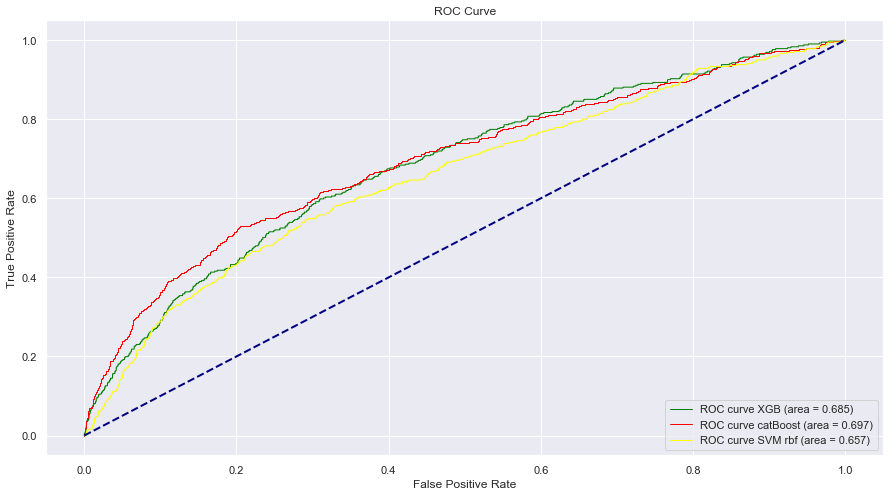

Precison score  Recall score  F1 score   AUC score  AUC proba
XGBoost         0.161742      0.247031   0.195489   0.583702   0.684675
catBoost        0.120433      0.422803   0.187467   0.615375   0.656880

In [92]:
fpr_cross_xg, tpr_cross_xg, thresholds = roc_curve(y, proba_xg[:,1])
fpr_cross_cat, tpr_cross_cat, thresholds = roc_curve(y, proba_cat[:,1])
fpr_cross_rbf, tpr_cross_rbf, thresholds = roc_curve(y, proba_rbf[:,1])


plt.figure(figsize=(15,8))
plt.plot(fpr_cross_xg, tpr_cross_xg, lw=1,color='green', label='ROC curve XGB (area = %0.3f)' % auc(fpr_cross_xg,tpr_cross_xg))
plt.plot(fpr_cross_cat, tpr_cross_cat, lw=1,color='red', label='ROC curve catBoost (area = %0.3f)' % auc(fpr_cross_cat,tpr_cross_cat))
plt.plot(fpr_cross_rbf, tpr_cross_rbf, lw=1,color='yellow', label='ROC curve SVM rbf (area = %0.3f)' % auc(fpr_cross_rbf,tpr_cross_rbf))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.show()

df_Evaluation=pd.DataFrame(columns=['Precison score','Recall score','F1 score ', 'AUC score','AUC proba'])
df_Evaluation.loc['XGBoost']=[precision_score(y, proba_xg_classes),recall_score(y, proba_xg_classes),f1_score(y, proba_xg_classes),roc_auc_score(y, proba_xg_classes),auc(fpr_cross_xg,tpr_cross_xg)]
df_Evaluation.loc['catBoost']=[precision_score(y, proba_cat_classes),recall_score(y, proba_cat_classes),f1_score(y, proba_cat_classes),roc_auc_score(y, proba_cat_classes),auc(fpr_cross_cat,tpr_cross_cat)]
df_Evaluation.loc['catBoost']=[precision_score(y, proba_rbf_classes),recall_score(y, proba_rbf_classes),f1_score(y, proba_rbf_classes),roc_auc_score(y, proba_rbf_classes),auc(fpr_cross_rbf,tpr_cross_rbf)]
df_Evaluation




### sous-échantillonnage

In [16]:
df_Services=df_not_scaled.dropna()[df_not_scaled.dropna().SECTEUR=='SERVICES']
df_Commerce=df_not_scaled.dropna()[df_not_scaled.dropna().SECTEUR=='COMMERCE']
df_Industrie=df_not_scaled.dropna()[df_not_scaled.dropna().SECTEUR=='INDUSTRIE']

In [17]:
def createSample(df):
    S=pd.concat([df[df.DEFAUT==0].sample(2*len(df[df.DEFAUT==1]),random_state=0),df[df.DEFAUT==1]])
    return S.sample(frac=1)

In [18]:
sample_Services=createSample(df_Services)
sample_Commerce=createSample(df_Commerce)
sample_Industrie=createSample(df_Industrie)

In [19]:
sample_Commerce.groupby('DEFAUT').DEFAUT.count()

DEFAUT
0    264
1    132
Name: DEFAUT, dtype: int64

In [20]:
Accuracy_Rate_table=Series_Single.sort_values(by='Accuracy Rate',ascending=False)[:9].drop(['CA_AE','EBE_TOT_BL','CFN_Pass_courant'])
Accuracy_Rate_table
#corrélé CA_TOT_BL et CA_AE : 0.728 -> on enlève CA_AE?
#ROA et  EBE_TOT_BL : 0.879 on enlève EBE_TOT_BL
#ROA et CFN_Pass_courant : 0.763 on enlève CFN_pass_courant

Accuracy Rate
DT_CA          35.118742
CA_TOT_BL      32.639752
TN_CA          31.721145
Ch_Fin_CA      28.428539
ROA            24.762356
AI_CA          24.605711

In [21]:
df_under=pd.concat([sample_Commerce,sample_Industrie,sample_Services]).sample(frac=1,random_state=0)
X_selected=df_under.loc[:,Accuracy_Rate_table.index.tolist()]
y_selected=df_under.DEFAUT

In [22]:
df_under.groupby('DEFAUT').DEFAUT.count()

DEFAUT
0    842
1    421
Name: DEFAUT, dtype: int64

In [23]:
X_selected.describe()

DT_CA    CA_TOT_BL        TN_CA    Ch_Fin_CA          ROA  \
count  1263.000000  1263.000000  1263.000000  1263.000000  1263.000000   
mean      0.940777     1.169300    -0.071121     0.025049     0.068355   
std       0.735013     0.898867     0.161709     0.024786     0.145533   
min       0.000163     0.000023    -0.327081     0.000000    -0.214459   
25%       0.352561     0.503734    -0.177721     0.003546     0.001836   
50%       0.710465     0.951701    -0.040143     0.015314     0.050522   
75%       1.433265     1.588263     0.016033     0.043650     0.140359   
max       2.229127     3.527065     0.244985     0.068685     0.384675   

             AI_CA  
count  1263.000000  
mean      0.379143  
std       0.372014  
min      -0.002556  
25%       0.068861  
50%       0.210682  
75%       0.676245  
max       1.006437

In [24]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size = 0.2,random_state=0,stratify=y_selected)

#{colsample_bytree= 1, max_depth= 6, min_child_weight= 8, reg_alpha= 0.15, reg_lambda= 0.25, scale_pos_weight= 28, silent= 1}
xg = XGBClassifier(n_estimators=1000,objective='binary:logistic',learning_rate=0.01,colsample_bytree= 1, max_depth= 6, min_child_weight= 6, reg_alpha= 0.15, reg_lambda= 0.2, scale_pos_weight= 3.5)
xg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=True,eval_metric='auc')


y_pred_xg = xg.predict_proba(X_test)
y_pred_xg_classes = xg.predict(X_test)

print(confusion_matrix(y_test, y_pred_xg_classes))  
print(classification_report(y_test, y_pred_xg_classes))
print(roc_auc_score(y_test, y_pred_xg_classes))

[0]	validation_0-auc:0.809928	validation_1-auc:0.679487
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.815217	validation_1-auc:0.684031
[2]	validation_0-auc:0.815733	validation_1-auc:0.68949
[3]	validation_0-auc:0.814604	validation_1-auc:0.684489
[4]	validation_0-auc:0.815907	validation_1-auc:0.684982
[5]	validation_0-auc:0.815466	validation_1-auc:0.683925
[6]	validation_0-auc:0.817331	validation_1-auc:0.685263
[7]	validation_0-auc:0.820528	validation_1-auc:0.68632
[8]	validation_0-auc:0.819503	validation_1-auc:0.683679
[9]	validation_0-auc:0.822717	validation_1-auc:0.689138
[10]	validation_0-auc:0.828233	validation_1-auc:0.692167
[11]	validation_0-auc:0.830644	validation_1-auc:0.682692
[12]	validation_0-auc:0.831584	validation_1-auc:0.681988
[13]	validation_0-auc:0.838658	validation_1-auc:0.68706
[14]	validation_0-auc:0.843244	validation_1-auc:0.683679
[

In [26]:
from catboost import CatBoostClassifier


np.random.seed(0)
random.seed(0)

model_F = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.1,
    scale_pos_weight=2,
    eval_metric='AUC',
#     use_best_model=False
)
model_F.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=True,
    plot=True
)

y_pred = model_F.predict_proba(X_test)
y_pred_classes = model_F.predict(X_test)
print(confusion_matrix(y_test, y_pred_classes))  
print(classification_report(y_test, y_pred_classes)) 
print(roc_auc_score(y_test, y_pred_classes))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6232389	best: 0.6232389 (0)	total: 41.6ms	remaining: 8.27s
1:	test: 0.6537405	best: 0.6537405 (1)	total: 74.3ms	remaining: 7.35s
2:	test: 0.6854396	best: 0.6854396 (2)	total: 110ms	remaining: 7.2s
3:	test: 0.6772330	best: 0.6854396 (2)	total: 143ms	remaining: 7.02s
4:	test: 0.6742392	best: 0.6854396 (2)	total: 175ms	remaining: 6.84s
5:	test: 0.6764934	best: 0.6854396 (2)	total: 204ms	remaining: 6.59s
6:	test: 0.6773035	best: 0.6854396 (2)	total: 234ms	remaining: 6.46s
7:	test: 0.6833967	best: 0.6854396 (2)	total: 272ms	remaining: 6.54s
8:	test: 0.6878698	best: 0.6878698 (8)	total: 302ms	remaining: 6.42s
9:	test: 0.6888912	best: 0.6888912 (9)	total: 333ms	remaining: 6.32s
10:	test: 0.6882573	best: 0.6888912 (9)	total: 369ms	remaining: 6.33s
11:	test: 0.6922020	best: 0.6922020 (11)	total: 405ms	remaining: 6.34s
12:	test: 0.6905114	best: 0.6922020 (11)	total: 439ms	remaining: 6.32s
13:	test: 0.6905114	best: 0.6922020 (11)	total: 475ms	remaining: 6.31s
14:	test: 0.6913215	best: 

116:	test: 0.6817413	best: 0.6985771 (101)	total: 5.94s	remaining: 4.21s
117:	test: 0.6801916	best: 0.6985771 (101)	total: 6.06s	remaining: 4.21s
118:	test: 0.6804734	best: 0.6985771 (101)	total: 6.17s	remaining: 4.2s
119:	test: 0.6787123	best: 0.6985771 (101)	total: 6.28s	remaining: 4.18s
120:	test: 0.6794167	best: 0.6985771 (101)	total: 6.38s	remaining: 4.17s
121:	test: 0.6784305	best: 0.6985771 (101)	total: 6.49s	remaining: 4.15s
122:	test: 0.6784305	best: 0.6985771 (101)	total: 6.6s	remaining: 4.13s
123:	test: 0.6776557	best: 0.6985771 (101)	total: 6.7s	remaining: 4.11s
124:	test: 0.6773739	best: 0.6985771 (101)	total: 6.8s	remaining: 4.08s
125:	test: 0.6775852	best: 0.6985771 (101)	total: 6.92s	remaining: 4.06s
126:	test: 0.6777261	best: 0.6985771 (101)	total: 7.05s	remaining: 4.05s
127:	test: 0.6780079	best: 0.6985771 (101)	total: 7.14s	remaining: 4.02s
128:	test: 0.6785714	best: 0.6985771 (101)	total: 7.25s	remaining: 3.99s
129:	test: 0.6776557	best: 0.6985771 (101)	total: 7.35s

In [75]:
print(len(y_train))
X_train.shape

1010


(1010, 6)

In [163]:
#LogisticRegression here
logit=LogisticRegression(class_weight={0:1,1:2.39})

logit.fit(X_train, y_train)

y_pred = logit.predict_proba(X_test)
y_pred_classes = logit.predict(X_test)
print(confusion_matrix(y_test, y_pred_classes))  
print(classification_report(y_test, y_pred_classes)) 
print(roc_auc_score(y_test, y_pred_classes))

[[120  49]
 [ 33  51]]
              precision    recall  f1-score   support

           0       0.78      0.71      0.75       169
           1       0.51      0.61      0.55        84

    accuracy                           0.68       253
   macro avg       0.65      0.66      0.65       253
weighted avg       0.69      0.68      0.68       253

0.6586010143702452


C:\Users\21694\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### Neural network

In [27]:
import tensorflow as tf
tf.get

In [30]:
class_weight = {0:3, 1:7}
import keras.backend as K
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

model_NN = Sequential()
model_NN.add(Dense(6, input_dim=6, kernel_initializer='normal', activation='relu'))
model_NN.add(Dense(10,activation='relu',))
model_NN.add(Dense(2, kernel_initializer='normal', activation='sigmoid'))
# Compile model
model_NN.compile(loss='binary_crossentropy', optimizer=keras.optimizers.adam(lr=0.001), metrics=[auc])


history=model_NN.fit(X_train.values, keras.utils.to_categorical(y_train), epochs=1000,validation_data=[X_test.values, keras.utils.to_categorical(y_test)],
          class_weight=class_weight)

Instructions for updating:
Use tf.cast instead.
Train on 1010 samples, validate on 253 samples
Epoch 1/1000
1010/1010 [==============================] - 1s 1ms/step - loss: 2.9989 - auc: 0.4839 - val_loss: 0.6950 - val_auc: 0.4425
Epoch 2/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.9830 - auc: 0.4275 - val_loss: 0.6962 - val_auc: 0.4223
Epoch 3/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.9543 - auc: 0.4295 - val_loss: 0.6965 - val_auc: 0.4418
Epoch 4/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.9123 - auc: 0.4537 - val_loss: 0.6959 - val_auc: 0.4679
Epoch 5/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.8616 - auc: 0.4808 - val_loss: 0.6928 - val_auc: 0.4969
Epoch 6/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.8191 - auc: 0.5108 - val_loss: 0.6864 - val_auc: 0.5232
Epoch 7/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.783

1010/1010 [==============================] - 0s 59us/step - loss: 2.6608 - auc: 0.6730 - val_loss: 0.6606 - val_auc: 0.6733
Epoch 59/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.6625 - auc: 0.6735 - val_loss: 0.6675 - val_auc: 0.6738
Epoch 60/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.6615 - auc: 0.6738 - val_loss: 0.6595 - val_auc: 0.6742
Epoch 61/1000
1010/1010 [==============================] - 0s 59us/step - loss: 2.6612 - auc: 0.6745 - val_loss: 0.6621 - val_auc: 0.6747
Epoch 62/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.6612 - auc: 0.6747 - val_loss: 0.6685 - val_auc: 0.6750
Epoch 63/1000
1010/1010 [==============================] - 0s 59us/step - loss: 2.6597 - auc: 0.6751 - val_loss: 0.6550 - val_auc: 0.6753
Epoch 64/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.6606 - auc: 0.6755 - val_loss: 0.6579 - val_auc: 0.6759
Epoch 65/1000
1010/1010 [=======================

1010/1010 [==============================] - 0s 51us/step - loss: 2.6289 - auc: 0.6943 - val_loss: 0.6600 - val_auc: 0.6943
Epoch 177/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.6295 - auc: 0.6944 - val_loss: 0.6586 - val_auc: 0.6944
Epoch 178/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.6282 - auc: 0.6945 - val_loss: 0.6626 - val_auc: 0.6945
Epoch 179/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.6270 - auc: 0.6945 - val_loss: 0.6610 - val_auc: 0.6946
Epoch 180/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.6279 - auc: 0.6946 - val_loss: 0.6574 - val_auc: 0.6947
Epoch 181/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.6269 - auc: 0.6947 - val_loss: 0.6589 - val_auc: 0.6948
Epoch 182/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.6280 - auc: 0.6948 - val_loss: 0.6604 - val_auc: 0.6949
Epoch 183/1000
1010/1010 [================

1010/1010 [==============================] - 0s 51us/step - loss: 2.6173 - auc: 0.6983 - val_loss: 0.6564 - val_auc: 0.6984
Epoch 236/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.6191 - auc: 0.6984 - val_loss: 0.6581 - val_auc: 0.6984
Epoch 237/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.6189 - auc: 0.6985 - val_loss: 0.6531 - val_auc: 0.6985
Epoch 238/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.6165 - auc: 0.6985 - val_loss: 0.6522 - val_auc: 0.6986
Epoch 239/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.6178 - auc: 0.6986 - val_loss: 0.6545 - val_auc: 0.6986
Epoch 240/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.6172 - auc: 0.6987 - val_loss: 0.6610 - val_auc: 0.6987
Epoch 241/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.6169 - auc: 0.6987 - val_loss: 0.6530 - val_auc: 0.6988
Epoch 242/1000
1010/1010 [================

1010/1010 [==============================] - 0s 51us/step - loss: 2.6127 - auc: 0.7014 - val_loss: 0.6569 - val_auc: 0.7014
Epoch 295/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.6201 - auc: 0.7014 - val_loss: 0.6551 - val_auc: 0.7014
Epoch 296/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.6091 - auc: 0.7014 - val_loss: 0.6570 - val_auc: 0.7015
Epoch 297/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.6074 - auc: 0.7015 - val_loss: 0.6628 - val_auc: 0.7015
Epoch 298/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.6077 - auc: 0.7015 - val_loss: 0.6535 - val_auc: 0.7015
Epoch 299/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.6115 - auc: 0.7015 - val_loss: 0.6550 - val_auc: 0.7016
Epoch 300/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.6076 - auc: 0.7016 - val_loss: 0.6562 - val_auc: 0.7017
Epoch 301/1000
1010/1010 [================

1010/1010 [==============================] - 0s 48us/step - loss: 2.6082 - auc: 0.7039 - val_loss: 0.6541 - val_auc: 0.7040
Epoch 354/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.6056 - auc: 0.7040 - val_loss: 0.6707 - val_auc: 0.7040
Epoch 355/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.6078 - auc: 0.7040 - val_loss: 0.6611 - val_auc: 0.7041
Epoch 356/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.6034 - auc: 0.7041 - val_loss: 0.6516 - val_auc: 0.7041
Epoch 357/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.6055 - auc: 0.7041 - val_loss: 0.6501 - val_auc: 0.7041
Epoch 358/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.6022 - auc: 0.7042 - val_loss: 0.6597 - val_auc: 0.7042
Epoch 359/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.6005 - auc: 0.7042 - val_loss: 0.6549 - val_auc: 0.7042
Epoch 360/1000
1010/1010 [================

1010/1010 [==============================] - 0s 51us/step - loss: 2.5917 - auc: 0.7065 - val_loss: 0.6517 - val_auc: 0.7065
Epoch 413/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5970 - auc: 0.7066 - val_loss: 0.6609 - val_auc: 0.7066
Epoch 414/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5946 - auc: 0.7066 - val_loss: 0.6624 - val_auc: 0.7066
Epoch 415/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5933 - auc: 0.7066 - val_loss: 0.6525 - val_auc: 0.7066
Epoch 416/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5930 - auc: 0.7066 - val_loss: 0.6609 - val_auc: 0.7066
Epoch 417/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5901 - auc: 0.7067 - val_loss: 0.6598 - val_auc: 0.7067
Epoch 418/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5911 - auc: 0.7067 - val_loss: 0.6478 - val_auc: 0.7067
Epoch 419/1000
1010/1010 [================

1010/1010 [==============================] - 0s 51us/step - loss: 2.5937 - auc: 0.7083 - val_loss: 0.6640 - val_auc: 0.7083
Epoch 472/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5849 - auc: 0.7083 - val_loss: 0.6557 - val_auc: 0.7083
Epoch 473/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5864 - auc: 0.7083 - val_loss: 0.6547 - val_auc: 0.7084
Epoch 474/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5870 - auc: 0.7084 - val_loss: 0.6657 - val_auc: 0.7084
Epoch 475/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5892 - auc: 0.7084 - val_loss: 0.6688 - val_auc: 0.7084
Epoch 476/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5850 - auc: 0.7084 - val_loss: 0.6605 - val_auc: 0.7084
Epoch 477/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5893 - auc: 0.7084 - val_loss: 0.6523 - val_auc: 0.7085
Epoch 478/1000
1010/1010 [================

1010/1010 [==============================] - 0s 51us/step - loss: 2.5826 - auc: 0.7096 - val_loss: 0.6559 - val_auc: 0.7096
Epoch 531/1000
1010/1010 [==============================] - 0s 48us/step - loss: 2.5855 - auc: 0.7097 - val_loss: 0.6656 - val_auc: 0.7097
Epoch 532/1000
1010/1010 [==============================] - 0s 48us/step - loss: 2.5830 - auc: 0.7097 - val_loss: 0.6566 - val_auc: 0.7097
Epoch 533/1000
1010/1010 [==============================] - 0s 59us/step - loss: 2.5851 - auc: 0.7097 - val_loss: 0.6579 - val_auc: 0.7097
Epoch 534/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5815 - auc: 0.7097 - val_loss: 0.6515 - val_auc: 0.7097
Epoch 535/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5846 - auc: 0.7098 - val_loss: 0.6707 - val_auc: 0.7098
Epoch 536/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5896 - auc: 0.7098 - val_loss: 0.6550 - val_auc: 0.7098
Epoch 537/1000
1010/1010 [================

1010/1010 [==============================] - 0s 51us/step - loss: 2.5812 - auc: 0.7108 - val_loss: 0.6605 - val_auc: 0.7109
Epoch 590/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5805 - auc: 0.7109 - val_loss: 0.6576 - val_auc: 0.7109
Epoch 591/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5795 - auc: 0.7109 - val_loss: 0.6623 - val_auc: 0.7109
Epoch 592/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5829 - auc: 0.7109 - val_loss: 0.6534 - val_auc: 0.7109
Epoch 593/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5824 - auc: 0.7109 - val_loss: 0.6596 - val_auc: 0.7109
Epoch 594/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5816 - auc: 0.7110 - val_loss: 0.6491 - val_auc: 0.7110
Epoch 595/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5798 - auc: 0.7110 - val_loss: 0.6672 - val_auc: 0.7110
Epoch 596/1000
1010/1010 [================

1010/1010 [==============================] - 0s 51us/step - loss: 2.5836 - auc: 0.7118 - val_loss: 0.6558 - val_auc: 0.7118
Epoch 649/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5796 - auc: 0.7118 - val_loss: 0.6570 - val_auc: 0.7118
Epoch 650/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5810 - auc: 0.7118 - val_loss: 0.6601 - val_auc: 0.7118
Epoch 651/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5786 - auc: 0.7118 - val_loss: 0.6626 - val_auc: 0.7118
Epoch 652/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5809 - auc: 0.7118 - val_loss: 0.6591 - val_auc: 0.7118
Epoch 653/1000
1010/1010 [==============================] - 0s 48us/step - loss: 2.5784 - auc: 0.7119 - val_loss: 0.6740 - val_auc: 0.7119
Epoch 654/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5797 - auc: 0.7119 - val_loss: 0.6565 - val_auc: 0.7119
Epoch 655/1000
1010/1010 [================

1010/1010 [==============================] - 0s 51us/step - loss: 2.5763 - auc: 0.7126 - val_loss: 0.6601 - val_auc: 0.7126
Epoch 708/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5753 - auc: 0.7126 - val_loss: 0.6616 - val_auc: 0.7126
Epoch 709/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5746 - auc: 0.7126 - val_loss: 0.6545 - val_auc: 0.7126
Epoch 710/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5761 - auc: 0.7126 - val_loss: 0.6652 - val_auc: 0.7126
Epoch 711/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5765 - auc: 0.7126 - val_loss: 0.6601 - val_auc: 0.7126
Epoch 712/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5752 - auc: 0.7126 - val_loss: 0.6602 - val_auc: 0.7126
Epoch 713/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5773 - auc: 0.7126 - val_loss: 0.6603 - val_auc: 0.7126
Epoch 714/1000
1010/1010 [================

1010/1010 [==============================] - 0s 51us/step - loss: 2.5712 - auc: 0.7133 - val_loss: 0.6579 - val_auc: 0.7133
Epoch 767/1000
1010/1010 [==============================] - 0s 67us/step - loss: 2.5741 - auc: 0.7133 - val_loss: 0.6570 - val_auc: 0.7133
Epoch 768/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5735 - auc: 0.7133 - val_loss: 0.6626 - val_auc: 0.7133
Epoch 769/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5750 - auc: 0.7133 - val_loss: 0.6593 - val_auc: 0.7133
Epoch 770/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5929 - auc: 0.7133 - val_loss: 0.6728 - val_auc: 0.7133
Epoch 771/1000
1010/1010 [==============================] - 0s 59us/step - loss: 2.5835 - auc: 0.7133 - val_loss: 0.6592 - val_auc: 0.7133
Epoch 772/1000
1010/1010 [==============================] - 0s 52us/step - loss: 2.5780 - auc: 0.7133 - val_loss: 0.6593 - val_auc: 0.7133
Epoch 773/1000
1010/1010 [================

1010/1010 [==============================] - 0s 48us/step - loss: 2.5726 - auc: 0.7139 - val_loss: 0.6596 - val_auc: 0.7139
Epoch 826/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5735 - auc: 0.7139 - val_loss: 0.6682 - val_auc: 0.7139
Epoch 827/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5771 - auc: 0.7139 - val_loss: 0.6545 - val_auc: 0.7139
Epoch 828/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5741 - auc: 0.7139 - val_loss: 0.6661 - val_auc: 0.7139
Epoch 829/1000
1010/1010 [==============================] - 0s 59us/step - loss: 2.5724 - auc: 0.7140 - val_loss: 0.6629 - val_auc: 0.7140
Epoch 830/1000
1010/1010 [==============================] - 0s 48us/step - loss: 2.5763 - auc: 0.7140 - val_loss: 0.6586 - val_auc: 0.7140
Epoch 831/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5711 - auc: 0.7140 - val_loss: 0.6648 - val_auc: 0.7140
Epoch 832/1000
1010/1010 [================

1010/1010 [==============================] - 0s 51us/step - loss: 2.5706 - auc: 0.7145 - val_loss: 0.6657 - val_auc: 0.7145
Epoch 885/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5740 - auc: 0.7145 - val_loss: 0.6536 - val_auc: 0.7145
Epoch 886/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5708 - auc: 0.7145 - val_loss: 0.6629 - val_auc: 0.7145
Epoch 887/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5694 - auc: 0.7145 - val_loss: 0.6682 - val_auc: 0.7145
Epoch 888/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5678 - auc: 0.7145 - val_loss: 0.6608 - val_auc: 0.7145
Epoch 889/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5726 - auc: 0.7145 - val_loss: 0.6655 - val_auc: 0.7145
Epoch 890/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5702 - auc: 0.7145 - val_loss: 0.6684 - val_auc: 0.7145
Epoch 891/1000
1010/1010 [================

1010/1010 [==============================] - 0s 51us/step - loss: 2.5708 - auc: 0.7150 - val_loss: 0.6654 - val_auc: 0.7150
Epoch 944/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5670 - auc: 0.7150 - val_loss: 0.6631 - val_auc: 0.7150
Epoch 945/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5644 - auc: 0.7151 - val_loss: 0.6680 - val_auc: 0.7151
Epoch 946/1000
1010/1010 [==============================] - 0s 59us/step - loss: 2.5698 - auc: 0.7151 - val_loss: 0.6552 - val_auc: 0.7151
Epoch 947/1000
1010/1010 [==============================] - 0s 51us/step - loss: 2.5651 - auc: 0.7151 - val_loss: 0.6589 - val_auc: 0.7151
Epoch 948/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5647 - auc: 0.7151 - val_loss: 0.6647 - val_auc: 0.7151
Epoch 949/1000
1010/1010 [==============================] - 0s 55us/step - loss: 2.5649 - auc: 0.7151 - val_loss: 0.6631 - val_auc: 0.7151
Epoch 950/1000
1010/1010 [================

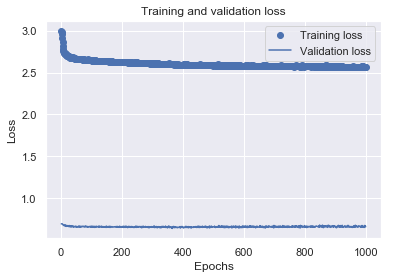

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [32]:
y_proba_NN=model_NN.predict(X_test)
y_classes_NN = model_NN.predict_classes(X_test)
print(confusion_matrix(y_classes_NN, y_test))  
print(classification_report(y_classes_NN,y_test))

[[109  33]
 [ 60  51]]
              precision    recall  f1-score   support

           0       0.64      0.77      0.70       142
           1       0.61      0.46      0.52       111

    accuracy                           0.63       253
   macro avg       0.63      0.61      0.61       253
weighted avg       0.63      0.63      0.62       253



### Score creation?


In [181]:
Accuracy_Rate_table

Accuracy Rate
DT_CA          35.118742
CA_TOT_BL      32.639752
TN_CA          31.721145
Ch_Fin_CA      28.428539
ROA            24.762356
AI_CA          24.605711

In [182]:
#Creating weights dict
dict_AUC=Accuracy_Rate_table['Accuracy Rate'].to_dict()
weights={}
for f in dict_AUC.keys():
    weights[f]=dict_AUC[f]/sum(dict_AUC.values())
weights

{'DT_CA': 0.19810179400814898,
 'CA_TOT_BL': 0.18411802385148804,
 'TN_CA': 0.1789362397880572,
 'Ch_Fin_CA': 0.16036293470532437,
 'ROA': 0.13968231534574524,
 'AI_CA': 0.13879869230123626}

In [183]:
X_selected_wScore=X_selected
def compute_score(row):
    L_features=row.index
    s=0
    s=sum(weights[x]*row[x] for x in L_features)
    return s
        
    
X_selected_wScore['Score']=X_selected.apply(lambda row: compute_score(row),axis=1)
#il fau voir d'autre critères 

In [184]:
X_selected_wScore.head()

DT_CA  CA_TOT_BL     TN_CA  Ch_Fin_CA       ROA     AI_CA     Score
2635  1.299875   0.405392 -0.238394   0.050188  0.025941  1.006437  0.440854
6326  0.357895   0.475000 -0.035088   0.068685  0.045000  0.042105  0.175222
236   0.178571   0.550098 -0.096429   0.010714  0.033399  0.489286  0.193699
5899  0.651061   1.153787 -0.126628   0.012372  0.025865  0.082461  0.335793
2425  0.642857   0.528889 -0.310924   0.048319  0.153333  1.006437  0.337952

In [185]:
roc_auc_score(y_selected,X_selected_wScore.Score)

0.5683137648738159

In [186]:
X_selected_whole_wScore=df_quanti.dropna().loc[:,Accuracy_Rate_table.index.tolist()]
def compute_score(row,weights):
    L_features=row.index
    s=0
    s=sum(weights[x]*row[x] for x in L_features)
    return s
        
    
X_selected_whole_wScore['Score']=X_selected_whole_wScore.apply(lambda row: compute_score(row,weights),axis=1)
#il fau voir d'autre critères 

In [187]:
roc_auc_score(df_quanti.dropna().DEFAUT,X_selected_whole_wScore.Score)

0.5764619971794007

In [188]:
def createList(val):
    #return [np.round(val-((val*2.5)/100),4),np.round(val,4),np.round(val-((val*2.5)/100),4)]
    return [np.round(val-((val*5)/100),4),np.round(val-((val*2.5)/100),4),np.round(val,4),
            np.round(val-((val*2.5)/100),4),np.round(val+((val*5)/100),4)]

list_of_weights={}
for (k,v) in weights.items():
    list_of_weights[k]=createList(weights[k])

In [189]:
list_of_weights

{'DT_CA': [0.1882, 0.1931, 0.1981, 0.1931, 0.208],
 'CA_TOT_BL': [0.1749, 0.1795, 0.1841, 0.1795, 0.1933],
 'TN_CA': [0.17, 0.1745, 0.1789, 0.1745, 0.1879],
 'Ch_Fin_CA': [0.1523, 0.1564, 0.1604, 0.1564, 0.1684],
 'ROA': [0.1327, 0.1362, 0.1397, 0.1362, 0.1467],
 'AI_CA': [0.1319, 0.1353, 0.1388, 0.1353, 0.1457]}

In [190]:
def product_dict(**kwargs):
    keys = kwargs.keys()
    vals = kwargs.values()
    for instance in itertools.product(*vals):
        yield dict(zip(keys, instance))
    
list_of_dicts=list(product_dict(**list_of_weights))
len(list_of_dicts)# 5 values for each feature : 5^6 = 15625 possibilties
#for 3 values 3^6=729

15625

In [191]:
#Note : this will take time ( 1 hour + ) - could be improved without apply and lambda
best_vals={}
best_AUC=-1
best_scores=[]
X_selected_whole_wScore=X_selected_whole_wScore.drop('Score',axis=1) #uncomment drop if first run
y=df_quanti.dropna().DEFAUT

for x in list_of_dicts:
    Scores=X_selected_whole_wScore.apply(lambda row: compute_score(row,x),axis=1)
    if (roc_auc_score(y,Scores)>best_AUC):
        best_AUC=roc_auc_score(y,Scores)
        best_vals=x
        best_scores=Scores
        print(best_AUC)
        print(best_vals)    

0.5764830516652519
{'DT_CA': 0.1882, 'CA_TOT_BL': 0.1749, 'TN_CA': 0.17, 'Ch_Fin_CA': 0.1523, 'ROA': 0.1327, 'AI_CA': 0.1319}
0.5774055890536325
{'DT_CA': 0.1882, 'CA_TOT_BL': 0.1749, 'TN_CA': 0.17, 'Ch_Fin_CA': 0.1523, 'ROA': 0.1327, 'AI_CA': 0.1353}
0.5783081246804543
{'DT_CA': 0.1882, 'CA_TOT_BL': 0.1749, 'TN_CA': 0.17, 'Ch_Fin_CA': 0.1523, 'ROA': 0.1327, 'AI_CA': 0.1388}
0.5800198543801576
{'DT_CA': 0.1882, 'CA_TOT_BL': 0.1749, 'TN_CA': 0.17, 'Ch_Fin_CA': 0.1523, 'ROA': 0.1327, 'AI_CA': 0.1457}


KeyboardInterrupt: 

In [192]:
print(best_AUC)
print(best_vals)
print(best_scores[:5])

0.5800198543801576
{'DT_CA': 0.1882, 'CA_TOT_BL': 0.1749, 'TN_CA': 0.17, 'Ch_Fin_CA': 0.1523, 'ROA': 0.1327, 'AI_CA': 0.1457}
0    0.417344
1    0.456175
2    0.372856
3    0.689371
4    0.688239
dtype: float64


### PCA Analysis

In [232]:
X=df_quanti.dropna().iloc[:,2:].values
y=df_quanti.dropna().DEFAUT.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,random_state=0,stratify=y) 

X_sc=StandardScaler().fit_transform(X_train)

pca = PCA(n_components=4)

principalComponents = pca.fit_transform(X_sc)
for i,x in enumerate(pca.explained_variance_ratio_):
    print('Variance expliqué de l axe %d est : %s'%(i+1,"{0:.2f}%".format(x * 100)) )
print("variance expliqué des 4 axes factoriels : ",np.round(np.sum(pca.explained_variance_ratio_)*100,4),'%')

Variance expliqué de l axe 1 est : 35.56%
Variance expliqué de l axe 2 est : 17.08%
Variance expliqué de l axe 3 est : 12.98%
Variance expliqué de l axe 4 est : 6.73%
variance expliqué des 4 axes factoriels :  72.3574 %


Les deux premiers axes n'expliquent qu'environ 52% de la variance totale,alors qu'en ajoutant les 2 autres axes la variance s'élève à ~72% 

In [238]:
#LogisticRegression here
pca.transform(X_test)
logit=LogisticRegression(class_weight={0:1,1:22})

logit.fit(X_train, y_train)

y_pred = logit.predict_proba(X_test)
y_pred_classes = logit.predict(X_test)
print(confusion_matrix(y_test, y_pred_classes))  
print(classification_report(y_test, y_pred_classes)) 
print(roc_auc_score(y_test, y_pred_classes))

[[871 483]
 [ 29  55]]
              precision    recall  f1-score   support

           0       0.97      0.64      0.77      1354
           1       0.10      0.65      0.18        84

    accuracy                           0.64      1438
   macro avg       0.54      0.65      0.47      1438
weighted avg       0.92      0.64      0.74      1438

0.6490205387915875


C:\Users\21694\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
